In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from scipy.sparse import lil_matrix
import pandas as pd
from IPython.display import display, HTML

rows = 10 
cols = 100  


X, Y = np.meshgrid(np.arange(cols), np.arange(rows))


vx = np.zeros((rows, cols))  
vy = np.zeros((rows, cols))  

VELOCIDAD_ENTRADA = 5.0  


Re = 50.0               
nu = 0.1                 
rho = 1.0               
U_IN = VELOCIDAD_ENTRADA 
L = cols * 1.0          



P = np.zeros((rows, cols))



vx[0, :] = 0; vx[-1, :] = 0
vy[0, :] = 0; vy[-1, :] = 0
vx[1:9, 0] = VELOCIDAD_ENTRADA 
vx[0, 0] = 0
vx[9, 0] = 0
vy[:, 0] = 0
vx[:, -1] = 0
vy[:, -1] = 0



for i in range(1, rows-1):
    for j in range(1, cols-1):
        factor_decay = np.exp(-0.5 * j / (cols-1)) 

        lateral_factor = np.exp(-0.5 * abs(i - rows/2) / (rows/2))
        vx[i, j] = VELOCIDAD_ENTRADA * factor_decay * lateral_factor
        

        vy[i, j] = 0.1 * np.sin(2 * np.pi * i / (rows-1)) * np.exp(-j/(cols/5))

In [ ]:
def calculate_F(vx, h=1.0):
    rows, cols = vx.shape
    F = np.zeros((rows-2, cols-2))
    vy_const = 0.05  
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            term1 = vx[i+1,j] + vx[i-1,j] + vx[i,j+1] + vx[i,j-1]
            term2 = (h/2) * vx[i,j] * (vx[i+1,j] - vx[i-1,j])
            term3 = (h/2) * vy_const * (vx[i,j+1] - vx[i,j-1])
            vx_calculated = vx[i,j] - (1/4) * (term1 - term2 - term3)
            F[i-1, j-1] = vx_calculated
    return F


def calculate_Jacobian_sparse(vx, h=1.0):
    """
    VERSIÓN SIMPLE - Solo para vx (sistema desacoplado)
    """
    rows, cols = vx.shape
    n = (rows-2) * (cols-2)
    J = lil_matrix((n, n))
    vy_const = 0.05  
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            idx = (i-1)*(cols-2) + (j-1)
            J[idx, idx] = 1 + (h/8)*(vx[i+1,j] - vx[i-1,j]) + (h/8)*vy_const*(vx[i,j+1] - vx[i,j-1])
            
            if i > 1:
                J[idx, idx - (cols-2)] = -0.25 + (h/8)*vx[i,j]
            if i < rows-2:
                J[idx, idx + (cols-2)] = -0.25 - (h/8)*vx[i,j]
            if j > 1:
                J[idx, idx - 1] = -0.25 + (h/8)*vy_const
            if j < cols-2:
                J[idx, idx + 1] = -0.25 - (h/8)*vy_const
    return J

def calculate_Jacobian_sparse_coupled(vx, vy, h=1.0):
    """
    VERSIÓN ACOPLADA - Para sistema vx-vy completo
    """
    rows, cols = vx.shape
    n_vars = 2 * (rows-2) * (cols-2)
    J = lil_matrix((n_vars, n_vars))
    
    visc_factor = 1.0 / Re if Re > 0 else 1.0
    

    for i in range(1, rows-1):
        for j in range(1, cols-1):

            idx_vx = 2 * ((i-1)*(cols-2) + (j-1))
            idx_vy = idx_vx + 1
            

            if j == 1:  
                J[idx_vx, idx_vx] = 1.0
            else:

                J[idx_vx, idx_vx] = 1 + (h/(2*Re)) * 4 + h * (vx[i,j+1] - vx[i,j-1])/(2*h)
                
            
                J[idx_vx, idx_vy] = h * (vx[i+1,j] - vx[i-1,j])/(2*h)
                
        
                if i > 1:
                    J[idx_vx, idx_vx - 2*(cols-2)] = -visc_factor - h*vy[i,j]/(2*h)
                if i < rows-2:
                    J[idx_vx, idx_vx + 2*(cols-2)] = -visc_factor + h*vy[i,j]/(2*h)
                if j > 1:
                    J[idx_vx, idx_vx - 2] = -visc_factor - h*vx[i,j]/(2*h)
                if j < cols-2:
                    J[idx_vx, idx_vx + 2] = -visc_factor + h*vx[i,j]/(2*h)
            
       
            J[idx_vy, idx_vy] = 1 + (h/(2*Re)) * 4 + h * (vy[i,j+1] - vy[i,j-1])/(2*h)
            J[idx_vy, idx_vx] = h * (vy[i+1,j] - vy[i-1,j])/(2*h)
            
       
            if i > 1:
                J[idx_vy, idx_vy - 2*(cols-2)] = -visc_factor - h*vy[i,j]/(2*h)
            if i < rows-2:
                J[idx_vy, idx_vy + 2*(cols-2)] = -visc_factor + h*vy[i,j]/(2*h)
            if j > 1:
                J[idx_vy, idx_vy - 2] = -visc_factor - h*vx[i,j]/(2*h)
            if j < cols-2:
                J[idx_vy, idx_vy + 2] = -visc_factor + h*vx[i,j]/(2*h)
    
    return J

In [ ]:
def solve_LU_scipy(A, B):
    """
    Resuelve el sistema usando scipy con mejor manejo de matrices mal condicionadas
    """
    from scipy.linalg import lu_solve, lu_factor
    import warnings
    
    try:

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                cond = np.linalg.cond(A)
                if cond > 1e10:
                    print(f"Matriz mal condicionada (cond={cond:.2e}), usando regularización")
                    A = A + 1e-4 * np.eye(A.shape[0])
            except:
             
                A = A + 1e-4 * np.eye(A.shape[0])
        
        lu, piv = lu_factor(A)
        return lu_solve((lu, piv), B)
    except:
 
        try:
            from scipy.linalg import svd
            U, s, Vt = svd(A, full_matrices=False)

            s_inv = np.where(s > 1e-10, 1/s, 0)
            return Vt.T @ (s_inv * (U.T @ B))
        except:

            return np.linalg.lstsq(A + 1e-3 * np.eye(A.shape[0]), B, rcond=None)[0]

Función calculate_F_9eq con las 9 ecuaciones implementada correctamente


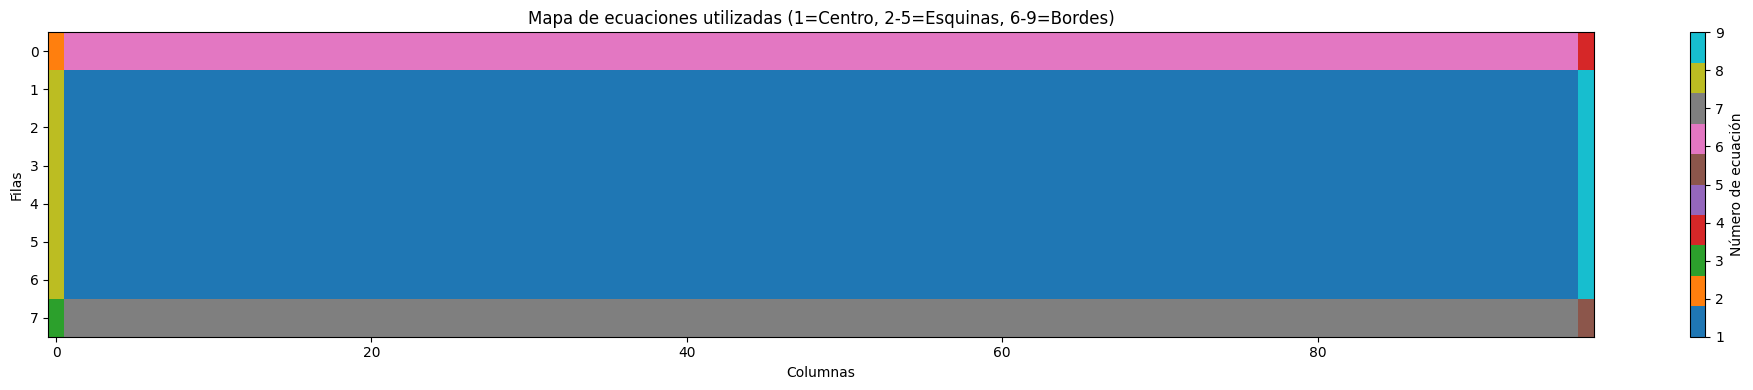


Resumen de ecuaciones por región:
Ecuación 1 (Centro): 576 puntos
Ecuación 2 (Esq. sup. izq.): 1 puntos
Ecuación 3 (Esq. inf. izq.): 1 puntos
Ecuación 4 (Esq. sup. der.): 1 puntos
Ecuación 5 (Esq. inf. der.): 1 puntos
Ecuación 6 (Borde superior): 96 puntos
Ecuación 7 (Borde inferior): 96 puntos
Ecuación 8 (Borde izquierdo): 6 puntos
Ecuación 9 (Borde derecho): 6 puntos


array([[2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 4],
       [8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 9],
       [8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
U_IN = VELOCIDAD_ENTRADA  
U_WALL = 0.0            

def calculate_F_9eq(vx, vy, h=1.0):
    """
    Calcula F aplicando las 9 ecuaciones específicas con términos de Navier-Stokes completos
    """
    rows, cols = vx.shape
    F = np.zeros((rows-2, cols-2))
    

    visc_factor = 1.0 / Re if Re > 0 else 1.0
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            fi = i - 1
            fj = j - 1
            

            d2vx_dx2 = (vx[i,j+1] - 2*vx[i,j] + vx[i,j-1]) / (h*h)
            d2vx_dy2 = (vx[i+1,j] - 2*vx[i,j] + vx[i-1,j]) / (h*h)
            visc_term = visc_factor * (d2vx_dx2 + d2vx_dy2)
            
  
            dvx_dx = (vx[i,j+1] - vx[i,j-1]) / (2*h)
            dvx_dy = (vx[i+1,j] - vx[i-1,j]) / (2*h)
            

            vx_limited = np.clip(vx[i,j], -100, 100)
            vy_limited = np.clip(vy[i,j], -100, 100)
            conv_term = vx_limited * dvx_dx + vy_limited * dvx_dy
            

            if j == 1:  
                F[fi, fj] = vx[i,j] - U_IN  
            else: 
                F[fi, fj] = -conv_term + visc_term
    
    return F

def calculate_G_9eq(vx, vy, h=1.0):
    """
    Calcula G para la componente vy de velocidad
    """
    rows, cols = vy.shape
    G = np.zeros((rows-2, cols-2))
    
    visc_factor = 1.0 / Re if Re > 0 else 1.0
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            fi = i - 1
            fj = j - 1
            
        
            d2vy_dx2 = (vy[i,j+1] - 2*vy[i,j] + vy[i,j-1]) / (h*h)
            d2vy_dy2 = (vy[i+1,j] - 2*vy[i,j] + vy[i-1,j]) / (h*h)
            visc_term = visc_factor * (d2vy_dx2 + d2vy_dy2)
            
         
            dvy_dx = (vy[i,j+1] - vy[i,j-1]) / (2*h)
            dvy_dy = (vy[i+1,j] - vy[i-1,j]) / (2*h)
            
            vx_limited = np.clip(vx[i,j], -100, 100)
            vy_limited = np.clip(vy[i,j], -100, 100)
            conv_term = vx_limited * dvy_dx + vy_limited * dvy_dy
            
            G[fi, fj] = -conv_term + visc_term
    
    return G



def mostrar_mapa_ecuaciones(rows=10, cols=100):
    """
    Muestra qué ecuación se usa en cada punto del dominio
    """
    mapa = np.zeros((rows-2, cols-2), dtype=int)
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            fi = i - 1
            fj = j - 1
            
            if i == 1 and j == 1:
                mapa[fi, fj] = 2  
            elif i == rows-2 and j == 1:
                mapa[fi, fj] = 3 
            elif i == 1 and j == cols-2:
                mapa[fi, fj] = 4 
            elif i == rows-2 and j == cols-2:
                mapa[fi, fj] = 5  
            elif i == 1:
                mapa[fi, fj] = 6 
            elif i == rows-2:
                mapa[fi, fj] = 7  
            elif j == 1:
                mapa[fi, fj] = 8 
            elif j == cols-2:
                mapa[fi, fj] = 9
            else:
                mapa[fi, fj] = 1 
    
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(20, 4))
    im = ax.imshow(mapa, cmap='tab10', aspect='auto')
    ax.set_title('Mapa de ecuaciones utilizadas (1=Centro, 2-5=Esquinas, 6-9=Bordes)')
    ax.set_xlabel('Columnas')
    ax.set_ylabel('Filas')
    
    cbar = plt.colorbar(im, ax=ax, ticks=range(1, 10))
    cbar.set_label('Número de ecuación')
    
    plt.tight_layout()
    plt.show()
    

    print("\nResumen de ecuaciones por región:")
    print(f"Ecuación 1 (Centro): {np.sum(mapa == 1)} puntos")
    print(f"Ecuación 2 (Esq. sup. izq.): {np.sum(mapa == 2)} puntos")
    print(f"Ecuación 3 (Esq. inf. izq.): {np.sum(mapa == 3)} puntos")
    print(f"Ecuación 4 (Esq. sup. der.): {np.sum(mapa == 4)} puntos")
    print(f"Ecuación 5 (Esq. inf. der.): {np.sum(mapa == 5)} puntos")
    print(f"Ecuación 6 (Borde superior): {np.sum(mapa == 6)} puntos")
    print(f"Ecuación 7 (Borde inferior): {np.sum(mapa == 7)} puntos")
    print(f"Ecuación 8 (Borde izquierdo): {np.sum(mapa == 8)} puntos")
    print(f"Ecuación 9 (Borde derecho): {np.sum(mapa == 9)} puntos")
    
    return mapa

# Verificar la implementación
print("Función calculate_F_9eq con las 9 ecuaciones implementada correctamente")
mostrar_mapa_ecuaciones(rows, cols)

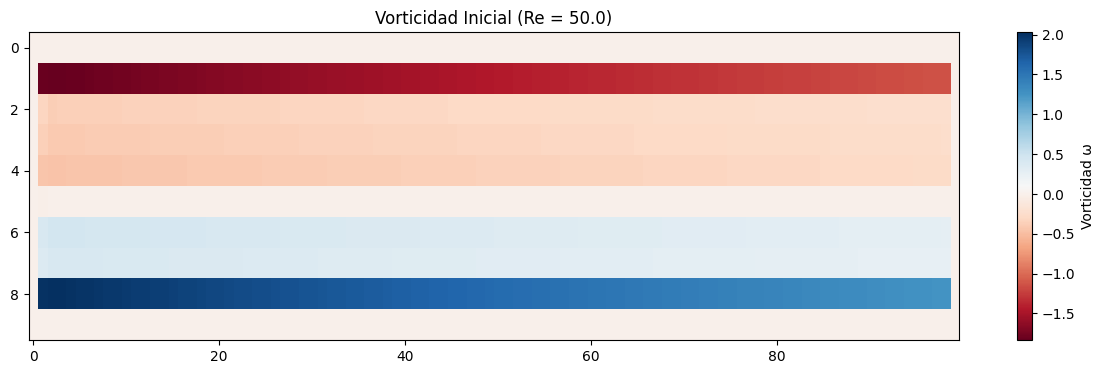

In [ ]:

def calculate_vorticity(vx, vy, h=1.0):
    """
    Calcula la vorticidad ω = ∂vy/∂x - ∂vx/∂y
    """
    rows, cols = vx.shape
    vorticity = np.zeros((rows, cols))
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            dvx_dy = (vx[i+1,j] - vx[i-1,j]) / (2*h)
            dvy_dx = (vy[i,j+1] - vy[i,j-1]) / (2*h)
            vorticity[i,j] = dvy_dx - dvx_dy
    
    return vorticity


vorticity_initial = calculate_vorticity(vx, vy)
plt.figure(figsize=(15, 4))
plt.imshow(vorticity_initial, cmap='RdBu', aspect='auto')
plt.colorbar(label='Vorticidad ω')
plt.title(f'Vorticidad Inicial (Re = {Re})')
plt.show()

In [59]:
cond_number = np.linalg.cond(calculate_Jacobian_sparse_coupled(vx, vy).toarray())
print("Número de condición:", cond_number)

Número de condición: 18.190003427540187


In [ ]:

def mostrar_tabla_velocidades(X, num_cols=20):
    tabla = X[1:-1, 1:-1].reshape((rows-2, cols-2))
    df = pd.DataFrame(tabla, index=[f"Fila {i+1}" for i in range(rows-2)],
                      columns=[f"Col {j+1}" for j in range(cols-2)])
    print("\nTabla de velocidades en la malla interna:\n")
    print(f"Mostrando primeras {min(num_cols, cols-2)} columnas:")
    print(df.iloc[:, :num_cols].round(4))
    return df

mostrar_tabla_velocidades(vx)


Tabla de velocidades en la malla interna:

Mostrando primeras 20 columnas:
         Col 1   Col 2   Col 3   Col 4   Col 5   Col 6   Col 7   Col 8  \
Fila 1  3.3347  3.3179  3.3012  3.2846  3.2680  3.2516  3.2352  3.2189   
Fila 2  3.6854  3.6669  3.6484  3.6300  3.6117  3.5935  3.5754  3.5574   
Fila 3  4.0730  4.0525  4.0321  4.0118  3.9916  3.9715  3.9515  3.9316   
Fila 4  4.5014  4.4787  4.4562  4.4337  4.4114  4.3891  4.3670  4.3450   
Fila 5  4.9748  4.9497  4.9248  4.9000  4.8753  4.8508  4.8263  4.8020   
Fila 6  4.5014  4.4787  4.4562  4.4337  4.4114  4.3891  4.3670  4.3450   
Fila 7  4.0730  4.0525  4.0321  4.0118  3.9916  3.9715  3.9515  3.9316   
Fila 8  3.6854  3.6669  3.6484  3.6300  3.6117  3.5935  3.5754  3.5574   

         Col 9  Col 10  Col 11  Col 12  Col 13  Col 14  Col 15  Col 16  \
Fila 1  3.2027  3.1865  3.1705  3.1545  3.1386  3.1228  3.1071  3.0914   
Fila 2  3.5395  3.5217  3.5039  3.4863  3.4687  3.4512  3.4338  3.4165   
Fila 3  3.9117  3.8920  3.8724  3.8

Col 1     Col 2     Col 3     Col 4     Col 5     Col 6     Col 7  \
Fila 1  3.334716  3.317916  3.301201  3.284570  3.268024  3.251560  3.235179   
Fila 2  3.685431  3.666864  3.648392  3.630012  3.611725  3.593530  3.575426   
Fila 3  4.073031  4.052512  4.032096  4.011783  3.991573  3.971464  3.951457   
Fila 4  4.501395  4.478718  4.456155  4.433706  4.411370  4.389147  4.367035   
Fila 5  4.974811  4.949749  4.924813  4.900003  4.875318  4.850758  4.826321   
Fila 6  4.501395  4.478718  4.456155  4.433706  4.411370  4.389147  4.367035   
Fila 7  4.073031  4.052512  4.032096  4.011783  3.991573  3.971464  3.951457   
Fila 8  3.685431  3.666864  3.648392  3.630012  3.611725  3.593530  3.575426   

           Col 8     Col 9    Col 10  ...    Col 89    Col 90    Col 91  \
Fila 1  3.218881  3.202665  3.186531  ...  2.138154  2.127383  2.116665   
Fila 2  3.557414  3.539493  3.521661  ...  2.363026  2.351122  2.339277   
Fila 3  3.931550  3.911744  3.892038  ...  2.611548  2.598391  2.585301   
Fila 4  4.345035  4.323146  4.301367  ...  2.886206  2.871666  2.857200   
Fila 5  4.802007  4.777815  4.753746  ...  3.189751  3.173682  3.157694   
Fila 6  4.345035  4.323146  4.301367  ...  2.886206  2.871666  2.857200   
Fila 7  3.931550  3.911744  3.892038  ...  2.611548  2.598391  2.585301   
Fila 8  3.557414  3.539493  3.521661  ...  2.363026  2.351122  2.339277   

          Col 92    Col 93    Col 94    Col 95    Col 96    Col 97    Col 98  
Fila 1  2.106002  2.095393  2.084837  2.074334  2.063884  2.053486  2.043141  
Fila 2  2.327492  2.315767  2.304101  2.292493  2.280944  2.269453  2.258020  
Fila 3  2.572277  2.559318  2.546425  2.533597  2.520833  2.508134  2.495498  
Fila 4  2.842806  2.828484  2.814235  2.800057  2.785951  2.771916  2.757952  
Fila 5  3.141786  3.125958  3.110211  3.094542  3.078952  3.063441  3.048008  
Fila 6  2.842806  2.828484  2.814235  2.800057  2.785951  2.771916  2.757952  
Fila 7  2.572277  2.559318  2.546425  2.533597  2.520833  2.508134  2.495498  
Fila 8  2.327492  2.315767  2.304101  2.292493  2.280944  2.269453  2.258020  

[8 rows x 98 columns]

In [ ]:

def mostrar_jacobiano(J, rows=20, cols=20):
    J_dense = J.toarray()
    
    df = pd.DataFrame(J_dense)
    

    print("Jacobiano (parcial):")
    with pd.option_context('display.max_rows', 20, 'display.max_columns', 20):
        display(df.iloc[:rows, :cols])

J = calculate_Jacobian_sparse(vx)
mostrar_jacobiano(J)

Jacobiano (parcial):


0         1         2         3         4         5         6   \
0   1.450166 -0.256250  0.000000  0.000000  0.000000  0.000000  0.000000   
1  -0.243750  1.458149 -0.256250  0.000000  0.000000  0.000000  0.000000   
2   0.000000 -0.243750  1.455841 -0.256250  0.000000  0.000000  0.000000   
3   0.000000  0.000000 -0.243750  1.453544 -0.256250  0.000000  0.000000   
4   0.000000  0.000000  0.000000 -0.243750  1.451259 -0.256250  0.000000   
5   0.000000  0.000000  0.000000  0.000000 -0.243750  1.448986 -0.256250   
6   0.000000  0.000000  0.000000  0.000000  0.000000 -0.243750  1.446724   
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 -0.243750   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
17  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
18  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
19  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9        10        11       12        13  \
0   0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
1   0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
2   0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
3   0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
4   0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
5   0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
6  -0.256250  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
7   1.444474 -0.256250  0.000000  0.00000  0.000000  0.00000  0.000000   
8  -0.243750  1.442234 -0.256250  0.00000  0.000000  0.00000  0.000000   
9   0.000000 -0.243750  1.440007 -0.25625  0.000000  0.00000  0.000000   
10  0.000000  0.000000 -0.243750  1.43779 -0.256250  0.00000  0.000000   
11  0.000000  0.000000  0.000000 -0.24375  1.435584 -0.25625  0.000000   
12  0.000000  0.000000  0.000000  0.00000 -0.243750  1.43339 -0.256250   
13  0.000000  0.000000  0.000000  0.00000  0.000000 -0.24375  1.431207   
14  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000 -0.243750   
15  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
16  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
17  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
18  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   
19  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000  0.000000   

          14        15        16        17        18        19  
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
12  0.000000 

In [ ]:

def verifica_convergencia_richardson(A):
    A = np.array(A, dtype=float)
    I = np.eye(A.shape[0])     
    Q = np.eye(A.shape[0])     
    
    try:
        Q_inv = np.linalg.inv(Q)      
        B = I - Q_inv @ A             
        norma_inf = np.linalg.norm(B, ord=np.inf)  
        
        print(f"Norma infinito de (I - Q^(-1) * A): {norma_inf:.6f}")
        if norma_inf <= 1:
            print("✅ El método puede converger (norma < 1)")
        else:
            print("❌ El método no garantiza convergencia (norma >= 1)")
    except np.linalg.LinAlgError:
        print("❌ No se pudo invertir la matriz Q (puede no ser invertible)")

verifica_convergencia_richardson(calculate_Jacobian_sparse(vx).toarray())


Norma infinito de (I - Q^(-1) * A): 1.737750
❌ El método no garantiza convergencia (norma >= 1)


In [ ]:
# SECCIÓN 6 - Verificar convergencia Jacobi
def verificar_convergencia_jacobi(A):
    n = A.shape[0]
    
    show_size = 5 if n > 10 else n
    D = np.diag(np.diag(A))
    
    try:
        D_inv = np.linalg.inv(D)
    except np.linalg.LinAlgError:
        raise ValueError("Matriz D no es invertible. El método de Jacobi no puede aplicarse.")
    
    M = np.eye(n) - D_inv @ A
    

    norma = np.linalg.norm(M, ord=np.inf)
    print(f"\nNorma ‖M‖∞ = {norma:.6f}")
    if norma <= 1:
        print("✅ El método puede converger (norma < 1)")
    else:
        print("❌ El método no garantiza convergencia (norma >= 1)")
    
    return norma <= 1, norma

verificar_convergencia_jacobi(calculate_Jacobian_sparse(vx).toarray())


Norma ‖M‖∞ = 1.824862
❌ El método no garantiza convergencia (norma >= 1)


(np.False_, np.float64(1.8248623653539697))

In [ ]:

def es_diagonalmente_dominante(A, estricta=False, por_filas=True):
    if A.shape[0] != A.shape[1]:
        raise ValueError("La matriz debe ser cuadrada")
    
    n = A.shape[0]
    
    if por_filas:
        for i in range(n):
            diag = abs(A[i, i])
            suma = np.sum(np.abs(A[i, :])) - diag  
            
            if estricta:
                if diag <= suma:
                    return False
            else:
                if diag < suma:
                    return False
    else:
        for j in range(n):
            diag = abs(A[j, j])
            suma = np.sum(np.abs(A[:, j])) - diag  
            
            if estricta:
                if diag <= suma:
                    return False
            else:
                if diag < suma:
                    return False
    
    return True

print(f"¿Es diagonalmente dominante?: {es_diagonalmente_dominante(calculate_Jacobian_sparse(vx).toarray())}")


¿Es diagonalmente dominante?: False


In [ ]:

def analizar_matriz(A):
    simetrica = np.allclose(A, A.T)
    
    autovalores = np.linalg.eigvals(A)
    
    if np.all(autovalores > 0):
        tipo = "Definida positiva"
    elif np.all(autovalores < 0):
        tipo = "Definida negativa"
    elif np.any(autovalores > 0) and np.any(autovalores < 0):
        tipo = "Indefinida (punto de silla)"
    else:
        tipo = "Semidefinida"
    
    return {
        "Simetrica": simetrica,
        "Tipo de matriz": tipo,
    }

print(analizar_matriz(calculate_Jacobian_sparse(vx, h=1.0).toarray()))

{'Simetrica': False, 'Tipo de matriz': 'Definida positiva'}


In [ ]:

vx_copy_LU = vx.copy()
vx_copy_jacobian = vx.copy()
vx_copy_gauss = vx.copy()
vx_copy_richardson = vx.copy()

In [ ]:
print("\n=== MÉTODO LU - SISTEMA ACOPLADO ===")

vx_copy_LU = vx.copy()
vy_copy_LU = vy.copy()

max_iter = 150
iter_LU = 0

for it in range(max_iter):
    # Calcular F y G
    F = calculate_F_9eq(vx_copy_LU, vy_copy_LU).flatten()
    G = calculate_G_9eq(vx_copy_LU, vy_copy_LU).flatten()
    
    # Sistema acoplado
    FG = np.zeros(2 * len(F))
    FG[0::2] = F 
    FG[1::2] = G  
    
    J = calculate_Jacobian_sparse_coupled(vx_copy_LU, vy_copy_LU)
    
    if np.any(np.isnan(FG)) or np.any(np.isnan(J.toarray())):
        print(f"NaN detectado en iteración {it+1}, deteniendo")
        iter_LU = it
        break

    delta_XY = solve_LU_scipy(J.toarray(), -FG) * 0.3 
    

    delta_vx = delta_XY[0::2].reshape((rows-2, cols-2))
    delta_vy = delta_XY[1::2].reshape((rows-2, cols-2))
    

    max_change = 0.5
    if np.max(np.abs(delta_vx)) > max_change:
        delta_vx = delta_vx * (max_change / np.max(np.abs(delta_vx)))
    if np.max(np.abs(delta_vy)) > max_change:
        delta_vy = delta_vy * (max_change / np.max(np.abs(delta_vy)))
    

    vx_copy_LU[1:-1, 1:-1] += delta_vx
    vy_copy_LU[1:-1, 1:-1] += delta_vy
    

    vx_copy_LU[1:-1, 0] = U_IN
    vy_copy_LU[:, 0] = 0
    
    norm_delta = np.linalg.norm(delta_XY)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_LU = it + 1
        break
    
    if it % 10 == 0:
        vort = calculate_vorticity(vx_copy_LU, vy_copy_LU)
        print(f"Iteración {it+1}: ||ΔXY|| = {norm_delta:.3e}, "
              f"Vort_max = {np.max(np.abs(vort)):.3e}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_LU = max_iter


=== MÉTODO LU - SISTEMA ACOPLADO ===
Iteración 1: ||ΔXY|| = 6.702e+00, Vort_max = 2.054e+00
Iteración 11: ||ΔXY|| = 4.713e+01, Vort_max = 2.147e+00
Iteración 21: ||ΔXY|| = 8.449e+01, Vort_max = 2.236e+00
Iteración 31: ||ΔXY|| = 5.633e+01, Vort_max = 2.306e+00
Iteración 41: ||ΔXY|| = 1.474e+03, Vort_max = 2.367e+00
Iteración 51: ||ΔXY|| = 2.730e+01, Vort_max = 2.429e+00
Iteración 61: ||ΔXY|| = 1.587e+01, Vort_max = 2.542e+00
Iteración 71: ||ΔXY|| = 2.604e+02, Vort_max = 3.791e+00
Iteración 81: ||ΔXY|| = 1.480e+01, Vort_max = 5.709e+00
Iteración 91: ||ΔXY|| = 8.684e+02, Vort_max = 6.940e+00
Iteración 101: ||ΔXY|| = 5.868e+02, Vort_max = 7.033e+00
Iteración 111: ||ΔXY|| = 4.241e+02, Vort_max = 7.147e+00
Iteración 121: ||ΔXY|| = 3.323e+02, Vort_max = 7.290e+00
Iteración 131: ||ΔXY|| = 2.963e+02, Vort_max = 7.477e+00
Iteración 141: ||ΔXY|| = 3.924e+02, Vort_max = 7.732e+00
Número máximo de iteraciones alcanzado


In [68]:
print("\n=== MÉTODO JACOBI OPTIMIZADO ===")
vx_copy_jacobian = vx.copy()
vy_copy_jacobian = vy.copy()

def Jacobi_vectorized(A, b, max_inner=50, tol=1e-7):
    """
    Implementación vectorizada del método de Jacobi con estabilización
    """
    n = len(b)
    x = np.zeros(n)
    
    diag = np.diag(A).copy() 
    diag[np.abs(diag) < 1e-10] = 1e-10
    
    D = np.diag(diag)
    R = A - D
    D_inv = np.diag(1.0 / diag)
    
    for k in range(max_inner):
        x_new = D_inv @ (b - R @ x)
        
        if np.max(np.abs(x_new - x)) > 1.0:
            x_new = x + (x_new - x) * (1.0 / np.max(np.abs(x_new - x)))
        
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    
    return x

max_iter = 150
iter_jacobi = 0

for it in range(max_iter):
    F = calculate_F_9eq(vx_copy_jacobian, vy_copy_jacobian).flatten()
    J = calculate_Jacobian_sparse(vx_copy_jacobian).toarray()
    
    if np.any(np.isnan(F)) or np.any(np.isnan(J)):
        print(f"NaN detectado en iteración {it+1}, deteniendo")
        iter_jacobi = it
        break

    delta_X = Jacobi_vectorized(J, -F, max_inner=30) * 0.05
    
    max_change = 0.3
    if np.max(np.abs(delta_X)) > max_change:
        delta_X = delta_X * (max_change / np.max(np.abs(delta_X)))
    
    vx_copy_jacobian[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_jacobi = it + 1
        break
    
    if it % 10 == 0:
        print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_jacobi = max_iter


=== MÉTODO JACOBI OPTIMIZADO ===
Iteración 1: ||ΔX|| = 8.388e-01
Iteración 11: ||ΔX|| = 1.125e+00
Iteración 21: ||ΔX|| = 1.076e+00
Iteración 31: ||ΔX|| = 7.003e-01
Iteración 41: ||ΔX|| = 5.277e-01
Iteración 51: ||ΔX|| = 4.756e-01
Iteración 61: ||ΔX|| = 3.018e-01
Iteración 71: ||ΔX|| = 3.001e-01
Iteración 81: ||ΔX|| = 3.000e-01
Iteración 91: ||ΔX|| = 3.000e-01
Iteración 101: ||ΔX|| = 3.000e-01
Iteración 111: ||ΔX|| = 3.000e-01
Iteración 121: ||ΔX|| = 3.000e-01
Iteración 131: ||ΔX|| = 3.000e-01
Iteración 141: ||ΔX|| = 3.000e-01
Número máximo de iteraciones alcanzado


In [69]:
print("\n=== MÉTODO RICHARDSON OPTIMIZADO ===")
vx_copy_richardson = vx.copy()
vy_copy_richardson = vy.copy() 

def Richardson_optimized(A, b, alpha=0.0001, max_inner=50, tol=1e-7):
    """
    Richardson con parámetro óptimo y estabilización
    """
    n = len(b)
    x = np.zeros(n)
    
    for k in range(max_inner):
        r = b - A @ x
        
        if np.max(np.abs(r)) > 10.0:
            r = r * (10.0 / np.max(np.abs(r)))
        
        x = x + alpha * r
        
        if np.linalg.norm(r) < tol:
            break
    
    return x

max_iter = 150
iter_richardson = 0

for it in range(max_iter):
    F = calculate_F_9eq(vx_copy_richardson, vy_copy_richardson).flatten()
    J = calculate_Jacobian_sparse(vx_copy_richardson).toarray()
    
    if np.any(np.isnan(F)) or np.any(np.isnan(J)):
        print(f"NaN detectado en iteración {it+1}, deteniendo")
        iter_richardson = it
        break
    
    alpha_opt = 0.0001
    
    delta_X = Richardson_optimized(J, -F, alpha=alpha_opt, max_inner=30) * 0.05
    
    max_change = 0.2
    if np.max(np.abs(delta_X)) > max_change:
        delta_X = delta_X * (max_change / np.max(np.abs(delta_X)))
    
    vx_copy_richardson[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_richardson = it + 1
        break
    
    if it % 10 == 0:
        print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_richardson = max_iter


=== MÉTODO RICHARDSON OPTIMIZADO ===
Iteración 1: ||ΔX|| = 1.465e-03
Iteración 11: ||ΔX|| = 1.463e-03
Iteración 21: ||ΔX|| = 1.460e-03
Iteración 31: ||ΔX|| = 1.457e-03
Iteración 41: ||ΔX|| = 1.454e-03
Iteración 51: ||ΔX|| = 1.452e-03
Iteración 61: ||ΔX|| = 1.449e-03
Iteración 71: ||ΔX|| = 1.446e-03
Iteración 81: ||ΔX|| = 1.444e-03
Iteración 91: ||ΔX|| = 1.441e-03
Iteración 101: ||ΔX|| = 1.438e-03
Iteración 111: ||ΔX|| = 1.436e-03
Iteración 121: ||ΔX|| = 1.433e-03
Iteración 131: ||ΔX|| = 1.430e-03
Iteración 141: ||ΔX|| = 1.428e-03
Número máximo de iteraciones alcanzado


In [ ]:
print("\n=== MÉTODO GAUSS-SEIDEL OPTIMIZADO ===")
vx_copy_gauss = vx.copy()
vy_copy_gauss = vy.copy()  # Añadir copia de vy

def GaussSeidel_SOR(A, b, omega=0.8, max_inner=50, tol=1e-7): 
    """
    Gauss-Seidel con sobre-relajación sucesiva (SOR) estabilizado
    """
    n = len(b)
    x = np.zeros(n)
    
    for k in range(max_inner):
        x_old = x.copy()
        
        for i in range(n):
            if abs(A[i, i]) < 1e-10: 
                continue
                
            sigma = np.dot(A[i, :i], x[:i]) + np.dot(A[i, i+1:], x_old[i+1:])
            x_new_i = (b[i] - sigma) / A[i, i]
            
            if abs(x_new_i - x_old[i]) > 1.0:
                x_new_i = x_old[i] + np.sign(x_new_i - x_old[i]) * 1.0
            
            x[i] = (1 - omega) * x_old[i] + omega * x_new_i
        
        if np.linalg.norm(x - x_old) < tol:
            break
    
    return x

max_iter = 150
iter_gauss = 0

for it in range(max_iter):
    F = calculate_F_9eq(vx_copy_gauss, vy_copy_gauss).flatten() 
    J = calculate_Jacobian_sparse(vx_copy_gauss).toarray()
    
    if np.any(np.isnan(F)) or np.any(np.isnan(J)):
        print(f"NaN detectado en iteración {it+1}, deteniendo")
        iter_gauss = it
        break
    
    delta_X = GaussSeidel_SOR(J, -F, omega=0.8, max_inner=30) * 0.05
    
    max_change = 0.3
    if np.max(np.abs(delta_X)) > max_change:
        delta_X = delta_X * (max_change / np.max(np.abs(delta_X)))
    
    vx_copy_gauss[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_gauss = it + 1
        break
    
    if it % 10 == 0:
        print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_gauss = max_iter


=== MÉTODO GAUSS-SEIDEL OPTIMIZADO ===
Iteración 1: ||ΔX|| = 8.361e-01
Iteración 11: ||ΔX|| = 1.106e+00
Iteración 21: ||ΔX|| = 1.046e+00
Iteración 31: ||ΔX|| = 1.155e+00
Iteración 41: ||ΔX|| = 6.623e-01
Iteración 51: ||ΔX|| = 7.878e-01
Iteración 61: ||ΔX|| = 8.845e-01
Iteración 71: ||ΔX|| = 9.814e-01
Iteración 81: ||ΔX|| = 1.002e+00
Iteración 91: ||ΔX|| = 9.758e-01
Iteración 101: ||ΔX|| = 1.106e+00
Iteración 111: ||ΔX|| = 1.184e+00
Iteración 121: ||ΔX|| = 1.181e+00
Iteración 131: ||ΔX|| = 1.367e+00
Iteración 141: ||ΔX|| = 1.506e+00
Número máximo de iteraciones alcanzado


In [71]:
print("\n=== MÉTODO RICHARDSON OPTIMIZADO ===")
vx_copy_richardson = vx.copy()
vy_copy_richardson = vy.copy()

def Richardson_optimized(A, b, alpha=0.0001, max_inner=50, tol=1e-7):
    """
    Richardson con parámetro óptimo y estabilización
    """
    n = len(b)
    x = np.zeros(n)
    
    for k in range(max_inner):
        r = b - A @ x
        

        if np.max(np.abs(r)) > 10.0:
            r = r * (10.0 / np.max(np.abs(r)))
        
        x = x + alpha * r
        
        if np.linalg.norm(r) < tol:
            break
    
    return x

max_iter = 150
iter_richardson = 0

for it in range(max_iter):
    F = calculate_F_9eq(vx_copy_richardson, vy_copy_richardson).flatten()
    J = calculate_Jacobian_sparse(vx_copy_richardson).toarray()
    

    if np.any(np.isnan(F)) or np.any(np.isnan(J)):
        print(f"NaN detectado en iteración {it+1}, deteniendo")
        iter_richardson = it
        break
    

    alpha_opt = 0.0001
    
    delta_X = Richardson_optimized(J, -F, alpha=alpha_opt, max_inner=30) * 0.05
    

    max_change = 0.2
    if np.max(np.abs(delta_X)) > max_change:
        delta_X = delta_X * (max_change / np.max(np.abs(delta_X)))
    
    vx_copy_richardson[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_richardson = it + 1
        break
    
    if it % 10 == 0:
        print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_richardson = max_iter


=== MÉTODO RICHARDSON OPTIMIZADO ===
Iteración 1: ||ΔX|| = 1.465e-03
Iteración 11: ||ΔX|| = 1.463e-03
Iteración 21: ||ΔX|| = 1.460e-03
Iteración 31: ||ΔX|| = 1.457e-03
Iteración 41: ||ΔX|| = 1.454e-03
Iteración 51: ||ΔX|| = 1.452e-03
Iteración 61: ||ΔX|| = 1.449e-03
Iteración 71: ||ΔX|| = 1.446e-03
Iteración 81: ||ΔX|| = 1.444e-03
Iteración 91: ||ΔX|| = 1.441e-03
Iteración 101: ||ΔX|| = 1.438e-03
Iteración 111: ||ΔX|| = 1.436e-03
Iteración 121: ||ΔX|| = 1.433e-03
Iteración 131: ||ΔX|| = 1.430e-03
Iteración 141: ||ΔX|| = 1.428e-03
Número máximo de iteraciones alcanzado


In [72]:
print("\n=== MÉTODO GRADIENTE DESCENDENTE ===")
vx_copy_gradient = vx.copy()
vy_copy_gradient = vy.copy()

def gradient_descent(A, b, x0=None, max_iter=100, tol=1e-7):
    """
    Método del Gradiente Descendente estabilizado
    """
    n = len(b)
    x = np.zeros(n) if x0 is None else x0.copy()
    
    for k in range(max_iter):
        r = b - A @ x
        
        Ar = A @ r
        denominator = np.dot(r, Ar)
        
        if abs(denominator) < 1e-10:
            alpha = 1e-4
        else:
            alpha = np.dot(r, r) / denominator
            alpha = min(alpha, 0.1) 
        
        x = x + alpha * r
        
        if np.linalg.norm(r) < tol:
            return x, k+1
    
    return x, max_iter

max_iter = 150
iter_gradient = 0

for it in range(max_iter):
    F = calculate_F_9eq(vx_copy_gradient, vy_copy_gradient).flatten()
    J = calculate_Jacobian_sparse(vx_copy_gradient).toarray()
    
    if np.any(np.isnan(F)) or np.any(np.isnan(J)):
        print(f"NaN detectado en iteración {it+1}, deteniendo")
        iter_gradient = it
        break
    
    JTJ = J.T @ J + 0.1 * np.eye(J.shape[1])
    JTF = J.T @ (-F)
    
    delta_X, inner_iters = gradient_descent(JTJ, JTF, max_iter=30, tol=1e-7)
    delta_X = delta_X * 0.05
    
    max_change = 0.3
    if np.max(np.abs(delta_X)) > max_change:
        delta_X = delta_X * (max_change / np.max(np.abs(delta_X)))
    
    vx_copy_gradient[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_gradient = it + 1
        break
    
    if it % 10 == 0:
        print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}, iter internas: {inner_iters}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_gradient = max_iter


=== MÉTODO GRADIENTE DESCENDENTE ===
Iteración 1: ||ΔX|| = 4.255e-01, iter internas: 30
Iteración 11: ||ΔX|| = 3.255e-01, iter internas: 30
Iteración 21: ||ΔX|| = 4.035e-01, iter internas: 30
Iteración 31: ||ΔX|| = 6.455e-01, iter internas: 30
Iteración 41: ||ΔX|| = 9.024e-01, iter internas: 30
Iteración 51: ||ΔX|| = 6.126e-01, iter internas: 30
Iteración 61: ||ΔX|| = 4.636e-01, iter internas: 30
Iteración 71: ||ΔX|| = 4.373e-01, iter internas: 30
Iteración 81: ||ΔX|| = 4.335e-01, iter internas: 30
Iteración 91: ||ΔX|| = 4.413e-01, iter internas: 30
Iteración 101: ||ΔX|| = 4.526e-01, iter internas: 30
Iteración 111: ||ΔX|| = 4.606e-01, iter internas: 30
Iteración 121: ||ΔX|| = 4.776e-01, iter internas: 30
Iteración 131: ||ΔX|| = 4.941e-01, iter internas: 30
Iteración 141: ||ΔX|| = 5.098e-01, iter internas: 30
Número máximo de iteraciones alcanzado


In [73]:
print("\n=== MÉTODO GRADIENTE CONJUGADO ===")
vx_copy_conjugate = vx.copy()
vy_copy_conjugate = vy.copy()

def conjugate_gradient(A, b, x0=None, max_iter=100, tol=1e-7):
    """
    Método del Gradiente Conjugado estabilizado
    """
    n = len(b)
    x = np.zeros(n) if x0 is None else x0.copy()
    
    r = b - A @ x
    p = r.copy()
    rsold = np.dot(r, r)
    
    for k in range(min(n, max_iter)):
        Ap = A @ p
        denominator = np.dot(p, Ap)
        
        if abs(denominator) < 1e-10:
            break
            
        alpha = rsold / denominator
        alpha = min(alpha, 0.5)
        
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = np.dot(r, r)
        
        if np.sqrt(rsnew) < tol:
            return x, k+1
        
        beta = rsnew / rsold
        p = r + beta * p
        rsold = rsnew
    
    return x, k+1

max_iter = 150
iter_conjugate = 0

for it in range(max_iter):
    F = calculate_F_9eq(vx_copy_conjugate, vy_copy_conjugate).flatten()
    J = calculate_Jacobian_sparse(vx_copy_conjugate).toarray()
    
    if np.any(np.isnan(F)) or np.any(np.isnan(J)):
        print(f"NaN detectado en iteración {it+1}, deteniendo")
        iter_conjugate = it
        break
    
    JTJ = J.T @ J + 0.1 * np.eye(J.shape[1])
    JTF = J.T @ (-F)
    
    delta_X, inner_iters = conjugate_gradient(JTJ, JTF, max_iter=30, tol=1e-7)
    delta_X = delta_X * 0.05
    
    max_change = 0.3
    if np.max(np.abs(delta_X)) > max_change:
        delta_X = delta_X * (max_change / np.max(np.abs(delta_X)))
    
    vx_copy_conjugate[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_conjugate = it + 1
        break
    
    if it % 10 == 0:
        print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}, iter internas: {inner_iters}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_conjugate = max_iter


=== MÉTODO GRADIENTE CONJUGADO ===
Iteración 1: ||ΔX|| = 6.257e-01, iter internas: 30
Iteración 11: ||ΔX|| = 5.426e-01, iter internas: 30
Iteración 21: ||ΔX|| = 8.266e-01, iter internas: 30
Iteración 31: ||ΔX|| = 1.046e+00, iter internas: 30
Iteración 41: ||ΔX|| = 1.057e+00, iter internas: 30
Iteración 51: ||ΔX|| = 6.212e-01, iter internas: 30
Iteración 61: ||ΔX|| = 5.520e-01, iter internas: 30
Iteración 71: ||ΔX|| = 5.188e-01, iter internas: 30
Iteración 81: ||ΔX|| = 5.022e-01, iter internas: 30
Iteración 91: ||ΔX|| = 4.928e-01, iter internas: 30
Iteración 101: ||ΔX|| = 4.867e-01, iter internas: 30
Iteración 111: ||ΔX|| = 4.826e-01, iter internas: 30
Iteración 121: ||ΔX|| = 4.796e-01, iter internas: 30
Iteración 131: ||ΔX|| = 4.773e-01, iter internas: 30
Iteración 141: ||ΔX|| = 4.756e-01, iter internas: 30
Número máximo de iteraciones alcanzado


In [ ]:
print("\n=== MÉTODO NEWTON-RAPHSON ===")
vx_copy_newton = vx.copy()
vy_copy_newton = vy.copy()

def newton_raphson_with_line_search(vx_current, vy_current, max_iter=100, tol=1e-6):
    """
    Newton-Raphson con búsqueda de línea para estabilidad
    """
    vx = vx_current.copy()
    vy = vy_current.copy()
    
    for it in range(max_iter):

        F = calculate_F_9eq(vx, vy).flatten()
        J = calculate_Jacobian_sparse(vx).toarray()
        

        try:
            # Usar descomposición LU de scipy
            from scipy.linalg import lu_solve, lu_factor
            lu, piv = lu_factor(J)
            delta_X = lu_solve((lu, piv), -F)
        except:
            # Si falla, usar mínimos cuadrados
            delta_X = np.linalg.lstsq(J, -F, rcond=None)[0]
        
        # Búsqueda de línea
        alpha = 1.0
        norm_F = np.linalg.norm(F)
        
        for _ in range(10): 
            vx_new = vx.copy()
            vx_new[1:-1, 1:-1] += (alpha * delta_X).reshape((rows-2, cols-2))
            F_new = calculate_F_9eq(vx_new, vy).flatten()
            norm_F_new = np.linalg.norm(F_new)
            
            if norm_F_new < norm_F:
                break
            alpha *= 0.5
        
        vx[1:-1, 1:-1] += (alpha * delta_X).reshape((rows-2, cols-2))
        
        norm_delta = np.linalg.norm(alpha * delta_X)
        print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}, α = {alpha:.3f}")
        
        if norm_delta < tol:
            return vx, vy, it + 1
    
    return vx, vy, max_iter

# Ejecutar Newton-Raphson
vx_copy_newton, vy_copy_newton, iter_newton = newton_raphson_with_line_search(
    vx_copy_newton, vy_copy_newton, max_iter=20, tol=1e-6
)


=== MÉTODO NEWTON-RAPHSON ===
Iteración 1: ||ΔX|| = 1.359e+01, α = 0.500
Iteración 2: ||ΔX|| = 4.311e+00, α = 0.125
Iteración 3: ||ΔX|| = 1.778e+00, α = 0.062
Iteración 4: ||ΔX|| = 8.184e-01, α = 0.031
Iteración 5: ||ΔX|| = 1.980e-01, α = 0.008
Iteración 6: ||ΔX|| = 1.966e-01, α = 0.008
Iteración 7: ||ΔX|| = 4.882e-02, α = 0.002
Iteración 8: ||ΔX|| = 4.874e-02, α = 0.002
Iteración 9: ||ΔX|| = 2.433e-02, α = 0.001
Iteración 10: ||ΔX|| = 2.431e-02, α = 0.001
Iteración 11: ||ΔX|| = 2.429e-02, α = 0.001
Iteración 12: ||ΔX|| = 2.427e-02, α = 0.001
Iteración 13: ||ΔX|| = 2.425e-02, α = 0.001
Iteración 14: ||ΔX|| = 2.423e-02, α = 0.001
Iteración 15: ||ΔX|| = 2.421e-02, α = 0.001
Iteración 16: ||ΔX|| = 2.420e-02, α = 0.001
Iteración 17: ||ΔX|| = 2.418e-02, α = 0.001
Iteración 18: ||ΔX|| = 2.416e-02, α = 0.001
Iteración 19: ||ΔX|| = 2.414e-02, α = 0.001
Iteración 20: ||ΔX|| = 2.413e-02, α = 0.001


In [75]:
# SECCIÓN 17 - Visualización de todos los métodos
print("\n=== RESUMEN DE CONVERGENCIA ===")
print(f"LU: {iter_LU} iteraciones")
print(f"Jacobi: {iter_jacobi} iteraciones")
print(f"Gauss-Seidel: {iter_gauss} iteraciones")
print(f"Richardson: {iter_richardson} iteraciones")
print(f"Gradiente Descendente: {iter_gradient} iteraciones")
print(f"Gradiente Conjugado: {iter_conjugate} iteraciones")
print(f"Newton-Raphson: {iter_newton} iteraciones")


def graficar_todos_los_metodos_completo(metodos_dict):
    """
    Visualiza todos los métodos numéricos
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    

    all_matrices = [m[0] for m in metodos_dict.values()]
    vmin = min(np.min(mat) for mat in all_matrices)
    vmax = max(np.max(mat) for mat in all_matrices)
    norm = Normalize(vmin=vmin, vmax=vmax)

    n_methods = len(metodos_dict)
    fig, axes = plt.subplots(n_methods, 1, figsize=(20, 4*n_methods))
    if n_methods == 1:
        axes = [axes]
    
    for idx, (nombre, (matriz, iteraciones)) in enumerate(metodos_dict.items()):
        ax = axes[idx]
        im = ax.imshow(matriz, cmap='viridis', norm=norm, aspect='auto', interpolation='bilinear')
        ax.set_title(f"{nombre} - Iteraciones: {iteraciones}", fontsize=14)
        ax.set_xlabel('Columnas', fontsize=12)
        ax.set_ylabel('Filas', fontsize=12)
        
        cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label('Velocidad vx', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n================== COMPARACIÓN DE RESULTADOS ==================")
    for nombre, (matriz, _) in metodos_dict.items():
        print(f"\n--- {nombre} ---")
        # Calcular estadísticas
        internal_values = matriz[1:-1, 1:-1]
        print(f"Mínimo: {np.min(internal_values):.6f}")
        print(f"Máximo: {np.max(internal_values):.6f}")
        print(f"Promedio: {np.mean(internal_values):.6f}")
        print(f"Desv. estándar: {np.std(internal_values):.6f}")
        
        # Mostrar muestra de valores (primeras 10 columnas)
        df = pd.DataFrame(internal_values[:, :10])
        df.index = [f"Fila {i+1}" for i in range(len(df))]
        df.columns = [f"Col {j+1}" for j in range(len(df.columns))]
        print("\nMuestra (primeras 10 columnas):")
        print(df.round(4))



=== RESUMEN DE CONVERGENCIA ===
LU: 150 iteraciones
Jacobi: 150 iteraciones
Gauss-Seidel: 150 iteraciones
Richardson: 150 iteraciones
Gradiente Descendente: 150 iteraciones
Gradiente Conjugado: 150 iteraciones
Newton-Raphson: 20 iteraciones



=== Analizando Re = 10 ===

Re = 10:
  Término convectivo máx: 1.7045e+01
  Término viscoso máx: 2.1817e-01
  Ratio conv/visc: 78.13
  Velocidad máxima: 10.4980

=== Analizando Re = 50 ===

Re = 50:
  Término convectivo máx: 8.8797e+00
  Término viscoso máx: 2.9452e-02
  Ratio conv/visc: 301.49
  Velocidad máxima: 6.6787

=== Analizando Re = 100 ===

Re = 100:
  Término convectivo máx: 8.6339e+00
  Término viscoso máx: 1.4168e-02
  Ratio conv/visc: 609.39
  Velocidad máxima: 6.2467


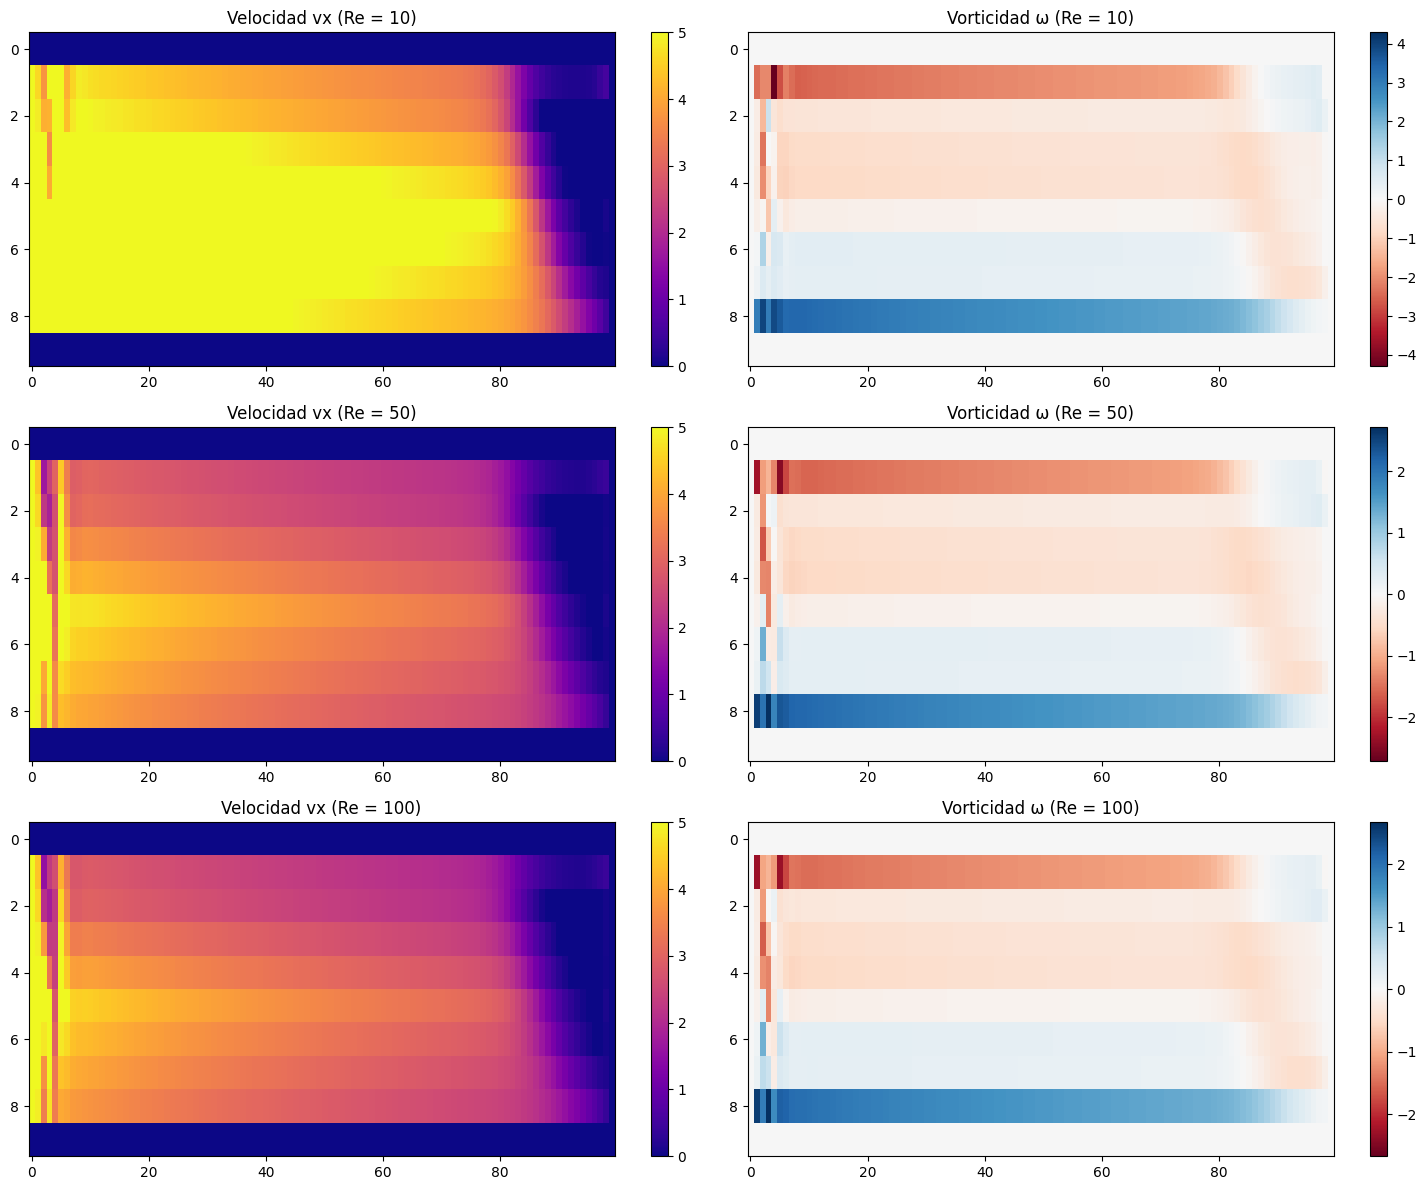

In [76]:
# SECCIÓN 18 - Análisis del efecto del número de Reynolds (CORREGIDA)
def analizar_efecto_reynolds(Re_values=[1, 10, 50, 100, 500]):
    """
    Analiza cómo el número de Reynolds afecta la solución
    """
    fig, axes = plt.subplots(len(Re_values), 2, figsize=(15, 4*len(Re_values)))
    
    # Guardar Re original
    Re_original = Re
    
    for idx, Re_test in enumerate(Re_values):
        print(f"\n=== Analizando Re = {Re_test} ===")
        
        # Actualizar Re global
        globals()['Re'] = Re_test
        
        # Resolver con el Re actual
        vx_test = vx.copy()
        vy_test = vy.copy()
        
        # Reinicializar para cada Re
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                factor_decay = np.exp(-0.5 * j / (cols-1))
                lateral_factor = np.exp(-0.5 * abs(i - rows/2) / (rows/2))
                vx_test[i, j] = VELOCIDAD_ENTRADA * factor_decay * lateral_factor
        
        # Condiciones de borde
        vx_test[1:-1, 0] = VELOCIDAD_ENTRADA
        vx_test[0, :] = 0
        vx_test[-1, :] = 0
        vx_test[:, -1] = 0
        
        # Resolver con método simplificado
        try:
            for iter in range(30):
                F = calculate_F_9eq(vx_test, vy_test).flatten()
                J = calculate_Jacobian_sparse(vx_test)
                
                # Verificar NaN
                if np.any(np.isnan(F)) or np.any(np.isnan(J.toarray())):
                    print(f"  NaN detectado en Re={Re_test}, iter={iter}")
                    break
                
                delta_X = solve_LU_scipy(J.toarray(), -F) * 0.05
                
                # Limitar cambios
                delta_X = np.clip(delta_X, -1, 1)
                
                vx_test[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
                
                # Mantener condiciones de borde
                vx_test[1:-1, 0] = VELOCIDAD_ENTRADA
                
                if np.linalg.norm(delta_X) < 1e-4:
                    print(f"  Convergencia en iter {iter}")
                    break
        except Exception as e:
            print(f"  Error en Re={Re_test}: {str(e)}")
            continue
        
        # Visualizar velocidad
        ax1 = axes[idx, 0]
        im1 = ax1.imshow(vx_test, cmap='plasma', aspect='auto', vmin=0, vmax=VELOCIDAD_ENTRADA)
        ax1.set_title(f'Velocidad vx (Re = {Re_test})')
        plt.colorbar(im1, ax=ax1)
        
        # Visualizar vorticidad
        vort = calculate_vorticity(vx_test, vy_test)
        ax2 = axes[idx, 1]
        vort_max = np.max(np.abs(vort))
        if vort_max > 0:
            im2 = ax2.imshow(vort, cmap='RdBu', aspect='auto', vmin=-vort_max, vmax=vort_max)
        else:
            im2 = ax2.imshow(vort, cmap='RdBu', aspect='auto')
        ax2.set_title(f'Vorticidad ω (Re = {Re_test})')
        plt.colorbar(im2, ax=ax2)
        
        # Análisis del término no lineal
        internal = vx_test[1:-1, 1:-1]
        if not np.any(np.isnan(internal)):
            grad_x = np.gradient(vx_test, axis=1)
            grad_xx = np.gradient(grad_x, axis=1)
            
            conv_term = np.abs(vx_test * grad_x)
            visc_term = np.abs(grad_xx / Re_test)
            
            conv_max = np.max(conv_term[1:-1, 1:-1])
            visc_max = np.max(visc_term[1:-1, 1:-1])
            
            print(f"\nRe = {Re_test}:")
            print(f"  Término convectivo máx: {conv_max:.4e}")
            print(f"  Término viscoso máx: {visc_max:.4e}")
            if visc_max > 0:
                print(f"  Ratio conv/visc: {conv_max/visc_max:.2f}")
            print(f"  Velocidad máxima: {np.max(internal):.4f}")
    
    # Restaurar Re original
    globals()['Re'] = Re_original
    
    plt.tight_layout()
    plt.show()

# Ejecutar análisis con menos valores de Re para evitar problemas
analizar_efecto_reynolds(Re_values=[10, 50, 100])


================== INFORMACIÓN DE VELOCIDAD ==================
Velocidad inicial configurada (VELOCIDAD_ENTRADA): 5.00
Número de Reynolds (Re): 50.00

--- LU ---
vx max: 9.3710, vy max: 12.8158, vort max: 8.0611

--- Jacobi ---
vx max: 33.7855, vy max: 0.0937, vort max: 14.6177

--- Gauss-Seidel ---
vx max: 13.0329, vy max: 0.0937, vort max: 6.0040

--- Richardson ---
vx max: 4.9754, vy max: 0.0937, vort max: 2.0284

--- Gradiente Descendente ---
vx max: 38.0111, vy max: 0.0937, vort max: 25.2322

--- Gradiente Conjugado ---
vx max: 39.3753, vy max: 0.0937, vort max: 26.5538

--- Newton-Raphson ---
vx max: 5.4323, vy max: 0.0937, vort max: 2.5569


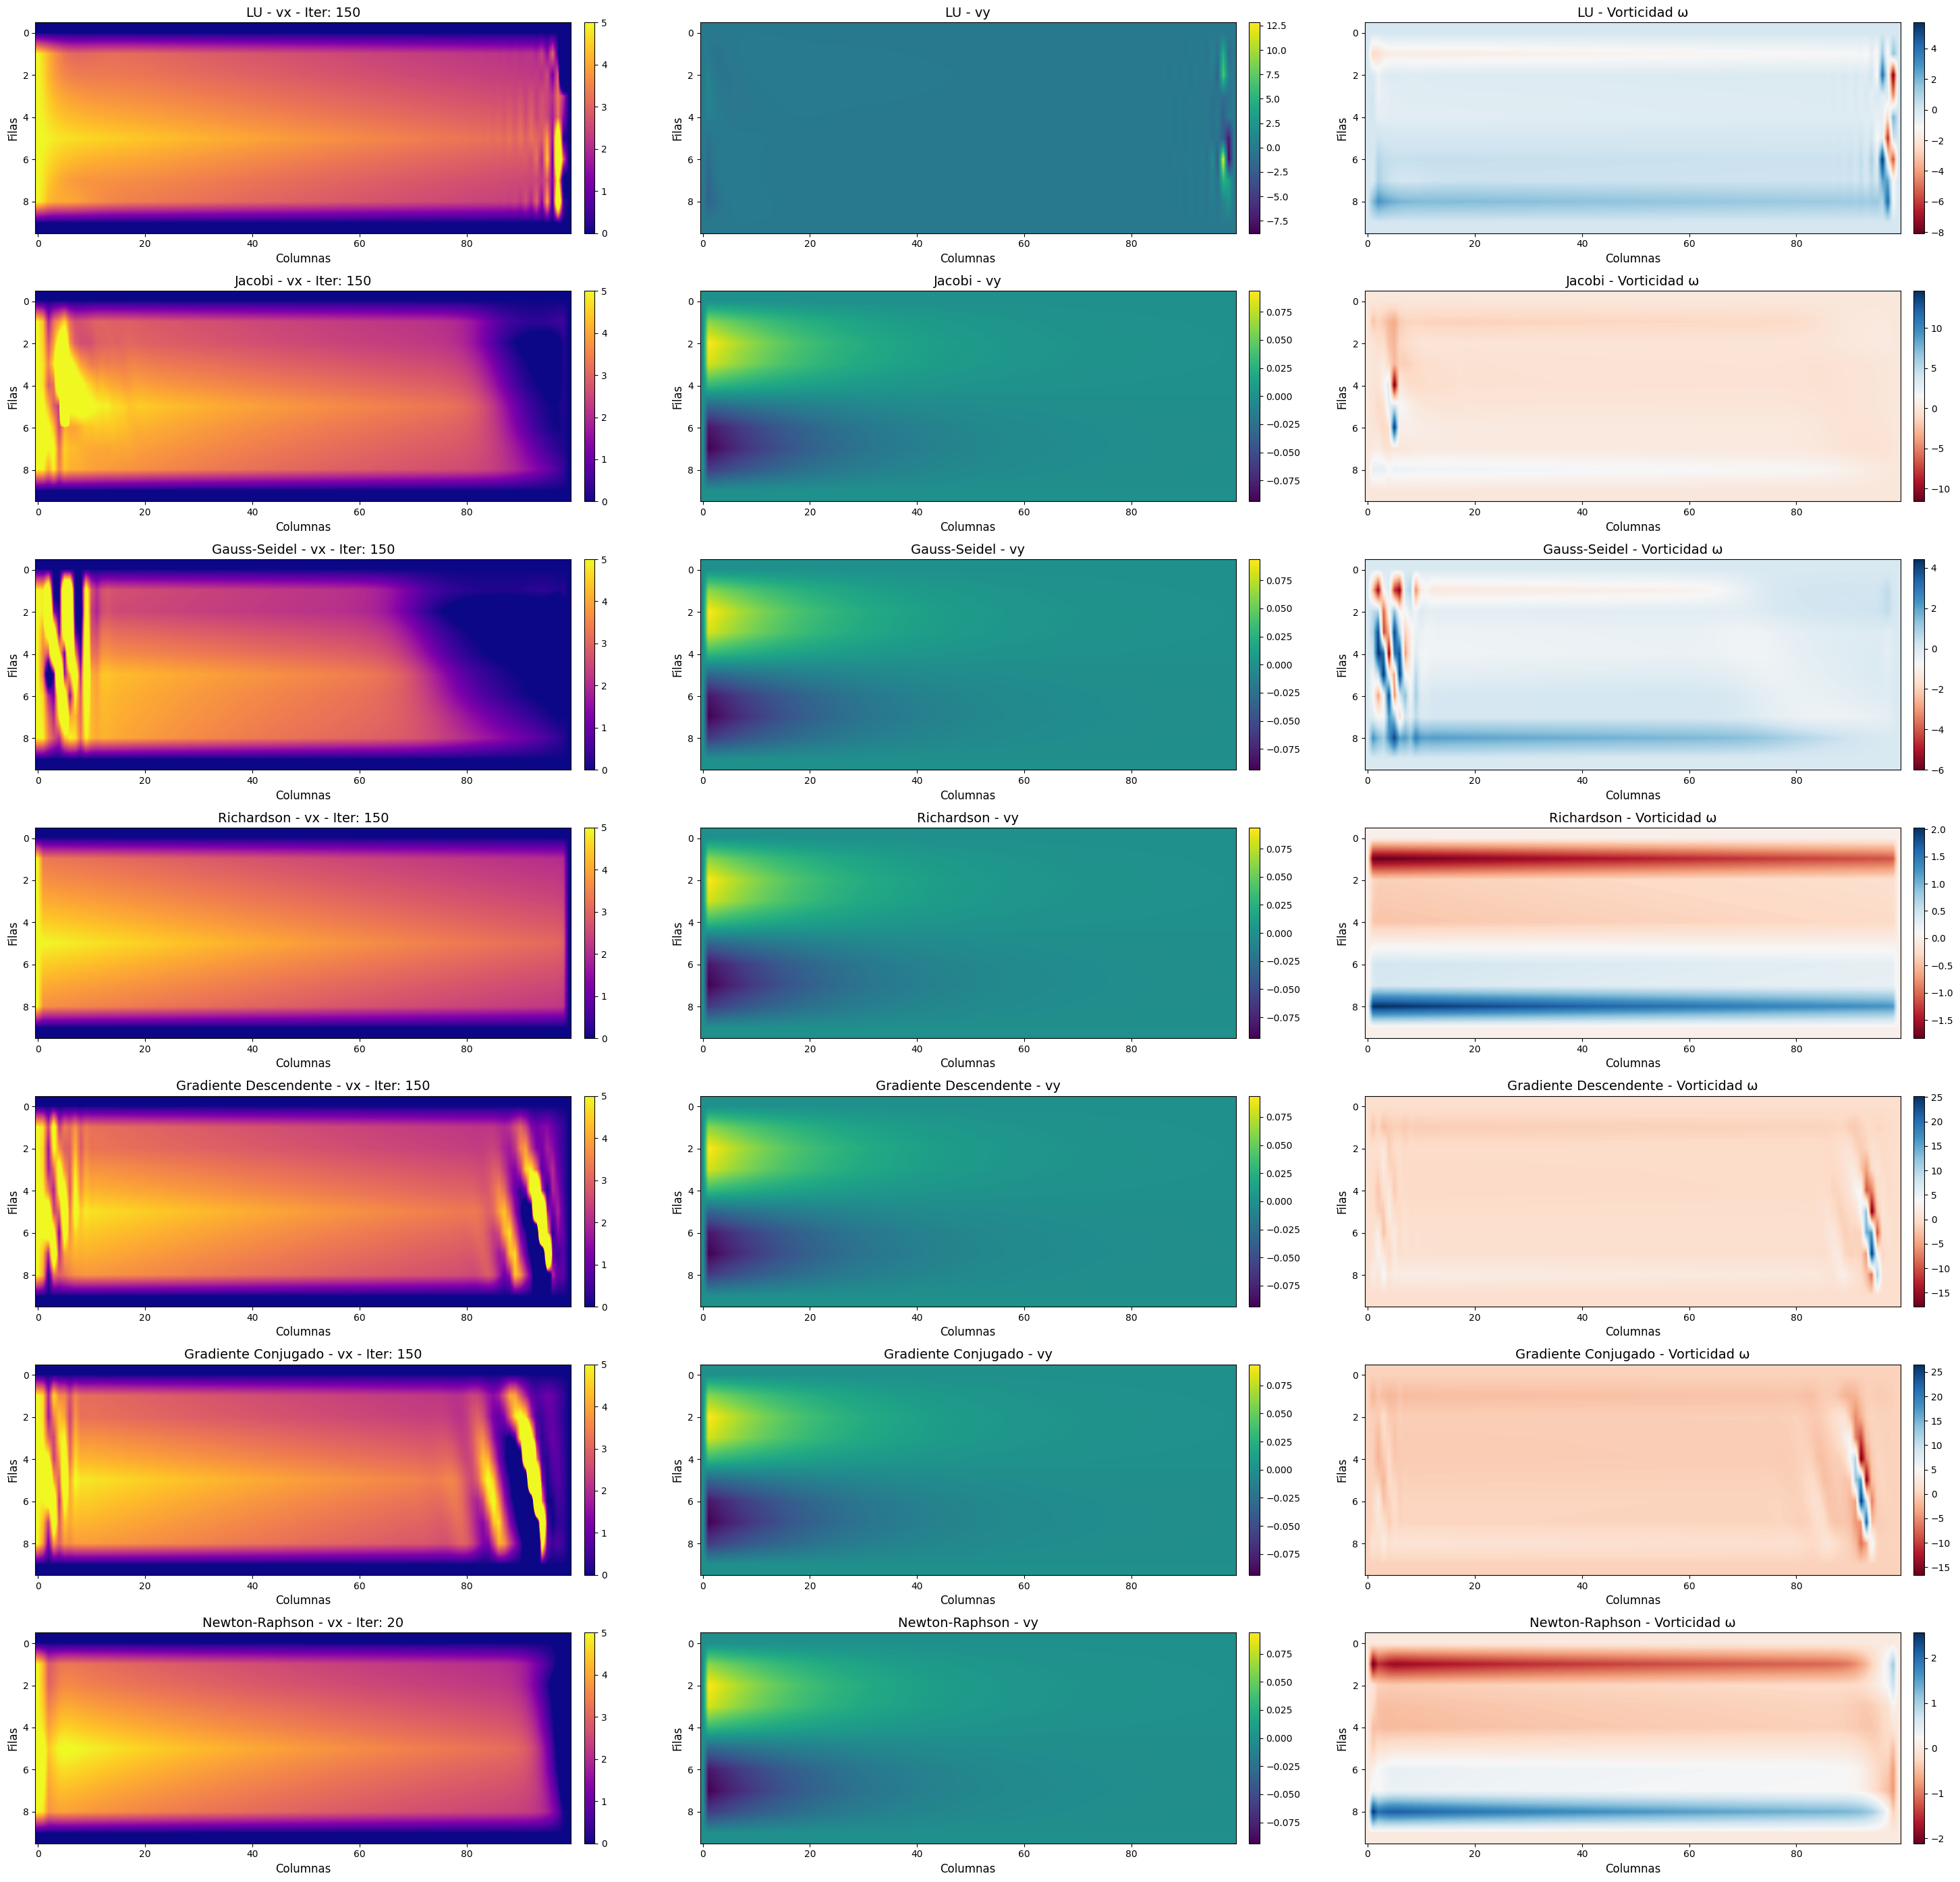


================== RESUMEN EJECUTIVO ==================
Velocidad de entrada configurada: 5.00

Método                  | Iter | V_borde | Estado
-------------------------------------------------------
LU                      |  150 |   5.000 | ✅ OK
Jacobi                  |  150 |   5.000 | ✅ OK
Gauss-Seidel            |  150 |   5.000 | ✅ OK
Richardson              |  150 |   5.000 | ✅ OK
Gradiente Descendente   |  150 |   5.000 | ✅ OK
Gradiente Conjugado     |  150 |   5.000 | ✅ OK
Newton-Raphson          |   20 |   5.000 | ✅ OK


In [77]:
def graficar_todos_los_metodos_completo(metodos_dict):
    """
    Visualiza todos los métodos numéricos incluyendo vx, vy y vorticidad
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    
    # Extraer solo vx para normalización
    all_vx_matrices = [m[0] for m in metodos_dict.values()]
    vmin = 0  
    vmax = VELOCIDAD_ENTRADA 
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    n_methods = len(metodos_dict)
    
    # Crear figura con 3 columnas: vx, vy, vorticidad
    fig, axes = plt.subplots(n_methods, 3, figsize=(30, 4*n_methods))
    if n_methods == 1:
        axes = axes.reshape(1, -1)
    
    print(f"\n================== INFORMACIÓN DE VELOCIDAD ==================")
    print(f"Velocidad inicial configurada (VELOCIDAD_ENTRADA): {VELOCIDAD_ENTRADA:.2f}")
    print(f"Número de Reynolds (Re): {Re:.2f}")
    print("="*60)
    
    for idx, (nombre, (matriz_vx, matriz_vy, iteraciones)) in enumerate(metodos_dict.items()):
        # Columna 1: vx
        ax_vx = axes[idx, 0]
        im_vx = ax_vx.imshow(matriz_vx, cmap='plasma', norm=norm, aspect='auto', interpolation='bilinear')
        ax_vx.set_title(f"{nombre} - vx - Iter: {iteraciones}", fontsize=14)
        ax_vx.set_xlabel('Columnas', fontsize=12)
        ax_vx.set_ylabel('Filas', fontsize=12)
        plt.colorbar(im_vx, ax=ax_vx, orientation='vertical', pad=0.02)
        
        # Columna 2: vy
        ax_vy = axes[idx, 1]
        im_vy = ax_vy.imshow(matriz_vy, cmap='viridis', aspect='auto', interpolation='bilinear')
        ax_vy.set_title(f"{nombre} - vy", fontsize=14)
        ax_vy.set_xlabel('Columnas', fontsize=12)
        ax_vy.set_ylabel('Filas', fontsize=12)
        plt.colorbar(im_vy, ax=ax_vy, orientation='vertical', pad=0.02)
        
        # Columna 3: vorticidad
        vort = calculate_vorticity(matriz_vx, matriz_vy)
        ax_vort = axes[idx, 2]
        im_vort = ax_vort.imshow(vort, cmap='RdBu', aspect='auto', interpolation='bilinear')
        ax_vort.set_title(f"{nombre} - Vorticidad ω", fontsize=14)
        ax_vort.set_xlabel('Columnas', fontsize=12)
        ax_vort.set_ylabel('Filas', fontsize=12)
        plt.colorbar(im_vort, ax=ax_vort, orientation='vertical', pad=0.02)
        
        # Estadísticas
        print(f"\n--- {nombre} ---")
        print(f"vx max: {np.max(matriz_vx[1:-1,1:-1]):.4f}, "
              f"vy max: {np.max(np.abs(matriz_vy[1:-1,1:-1])):.4f}, "
              f"vort max: {np.max(np.abs(vort)):.4f}")
    
    plt.tight_layout()
    plt.show()

    
# Ahora necesitamos incluir tanto vx como vy en los resultados
metodos_completos = {
    "LU": (vx_copy_LU, vy_copy_LU, iter_LU),
    "Jacobi": (vx_copy_jacobian, vy_copy_jacobian, iter_jacobi),
    "Gauss-Seidel": (vx_copy_gauss, vy_copy_gauss, iter_gauss),
    "Richardson": (vx_copy_richardson, vy_copy_richardson, iter_richardson),
    "Gradiente Descendente": (vx_copy_gradient, vy_copy_gradient, iter_gradient),
    "Gradiente Conjugado": (vx_copy_conjugate, vy_copy_conjugate, iter_conjugate),
    "Newton-Raphson": (vx_copy_newton, vy_copy_newton, iter_newton),
}


graficar_todos_los_metodos_completo(metodos_completos)


print("\n================== RESUMEN EJECUTIVO ==================")
print(f"Velocidad de entrada configurada: {VELOCIDAD_ENTRADA:.2f}")
print("\nMétodo                  | Iter | V_borde | Estado")
print("-" * 55)
for nombre, (matriz_vx, matriz_vy, iter) in metodos_completos.items():
    v_borde = np.max(matriz_vx[1:-1, 0])
    internal = matriz_vx[1:-1, 1:-1]
    
    if np.any(np.isnan(internal)):
        estado = "❌ NaN"
    elif np.any(np.isinf(internal)):
        estado = "❌ Infinito"
    elif np.max(np.abs(internal)) > 10 * VELOCIDAD_ENTRADA:
        estado = "⚠️  Inestable"
    else:
        estado = "✅ OK"
    
    print(f"{nombre:23} | {iter:4d} | {v_borde:7.3f} | {estado}")

## Añadiendo Splines

In [ ]:
from scipy.interpolate import RectBivariateSpline, interp2d
import numpy as np

def aplicar_splines_a_resultado(vx_matrix, factor_refinamiento=5):
    """
    Aplica interpolación con splines bivariados a la matriz de velocidades
    
    Parámetros:
    - vx_matrix: matriz de velocidades original
    - factor_refinamiento: cuántas veces más denso será el grid interpolado
    
    Retorna:
    - vx_interpolado: matriz interpolada más densa
    - X_fino, Y_fino: coordenadas del grid fino
    """
    rows, cols = vx_matrix.shape
    

    x = np.arange(cols)
    y = np.arange(rows)
    

    x_fino = np.linspace(0, cols-1, cols * factor_refinamiento)
    y_fino = np.linspace(0, rows-1, rows * factor_refinamiento)
    X_fino, Y_fino = np.meshgrid(x_fino, y_fino)
    

    interpolador = RectBivariateSpline(y, x, vx_matrix, kx=3, ky=3)
    

    vx_interpolado = interpolador(y_fino, x_fino)
    

    vx_interpolado[0, :] = 0
    vx_interpolado[-1, :] = 0
    

    indices_borde = np.where((Y_fino[:, 0] > 0) & (Y_fino[:, 0] < rows-1))[0]
    vx_interpolado[indices_borde, 0] = VELOCIDAD_ENTRADA
    

    vx_interpolado[:, -1] = 0
    
    return vx_interpolado, X_fino, Y_fino

def procesar_todos_con_splines(metodos_dict, factor_refinamiento=3):
    """
    Aplica splines a todos los métodos (actualizado para manejar vx, vy, iter)
    """
    metodos_con_splines = {}
    
    for nombre, (matriz_vx, matriz_vy, iteraciones) in metodos_dict.items():
        print(f"Aplicando splines a {nombre}...")
        matriz_interpolada, _, _ = aplicar_splines_a_resultado(matriz_vx, factor_refinamiento)
        metodos_con_splines[nombre] = (matriz_interpolada, iteraciones, matriz_vx)
    
    return metodos_con_splines

In [ ]:
def graficar_comparacion_con_splines(metodos_dict, factor_refinamiento=3):
    """
    Visualiza la comparación entre resultados originales y con splines
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    
    metodos_con_splines = procesar_todos_con_splines(metodos_dict, factor_refinamiento)
    
    n_methods = len(metodos_dict)
    fig, axes = plt.subplots(n_methods, 2, figsize=(24, 4*n_methods))
    
    if n_methods == 1:
        axes = axes.reshape(1, -1)
    
    vmin = 0
    vmax = VELOCIDAD_ENTRADA
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    print(f"\n================== COMPARACIÓN CON SPLINES ==================")
    print(f"Factor de refinamiento: {factor_refinamiento}x")
    print(f"Velocidad de entrada: {VELOCIDAD_ENTRADA:.2f}")
    print("="*60)
    
    for idx, (nombre, (matriz_spline, iteraciones, matriz_original)) in enumerate(metodos_con_splines.items()):

        matriz_vx_original = metodos_dict[nombre][0]
        

        ax_orig = axes[idx, 0]
        im1 = ax_orig.imshow(matriz_vx_original, cmap='plasma', norm=norm, 
                            aspect='auto', interpolation='nearest')
        ax_orig.set_title(f"{nombre} - Original ({matriz_vx_original.shape[0]}x{matriz_vx_original.shape[1]})", 
                         fontsize=12)
        ax_orig.set_xlabel('Columnas')
        ax_orig.set_ylabel('Filas')
        plt.colorbar(im1, ax=ax_orig, pad=0.02)

        ax_spline = axes[idx, 1]
        im2 = ax_spline.imshow(matriz_spline, cmap='plasma', norm=norm, 
                              aspect='auto', interpolation='bilinear')
        ax_spline.set_title(f"{nombre} - Splines ({matriz_spline.shape[0]}x{matriz_spline.shape[1]})", 
                           fontsize=12)
        ax_spline.set_xlabel('Columnas')
        ax_spline.set_ylabel('Filas')
        plt.colorbar(im2, ax=ax_spline, pad=0.02)
        
        print(f"\n{nombre}:")
        print(f"  Tamaño original: {matriz_vx_original.shape}")
        print(f"  Tamaño con splines: {matriz_spline.shape}")
        print(f"  Máx original: {np.max(matriz_vx_original):.4f}")
        print(f"  Máx con splines: {np.max(matriz_spline):.4f}")
        print(f"  Diferencia máxima: {np.max(np.abs(matriz_spline.max() - matriz_vx_original.max())):.4f}")
    
    plt.tight_layout()
    plt.show()


def graficar_solo_splines(metodos_dict, factor_refinamiento=4):
    """
    Visualiza solo los resultados con splines aplicados
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    
    metodos_con_splines = procesar_todos_con_splines(metodos_dict, factor_refinamiento)
    
    n_methods = len(metodos_dict)
    fig, axes = plt.subplots(n_methods, 1, figsize=(20, 4*n_methods))
    
    if n_methods == 1:
        axes = [axes]
    
    vmin = 0
    vmax = VELOCIDAD_ENTRADA
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    for idx, (nombre, (matriz_spline, iteraciones, _)) in enumerate(metodos_con_splines.items()):
        ax = axes[idx]
        
        im = ax.imshow(matriz_spline, cmap='plasma', norm=norm, 
                      aspect='auto', interpolation='bilinear')
        
        # Obtener velocidad del borde de la matriz vx original
        velocidad_borde_real = np.max(metodos_dict[nombre][0][1:-1, 0])
        
        titulo = f"{nombre} (Suavizado con Splines) - Iter: {iteraciones} - V_entrada: {velocidad_borde_real:.2f}/{VELOCIDAD_ENTRADA:.2f}"
        ax.set_title(titulo, fontsize=14)
        ax.set_xlabel('Columnas', fontsize=12)
        ax.set_ylabel('Filas', fontsize=12)
        
        cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label('Velocidad vx', fontsize=10)
    
    plt.tight_layout()
    plt.show()


def crear_animacion_flujo(vx_matrix, nombre_metodo, factor_refinamiento=3):
    """
    Crea líneas de corriente para visualizar mejor el flujo
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    

    vx_spline, X_fino, Y_fino = aplicar_splines_a_resultado(vx_matrix, factor_refinamiento)
    
    # Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    

    norm = Normalize(vmin=0, vmax=VELOCIDAD_ENTRADA)
    im = ax1.imshow(vx_spline, cmap='plasma', norm=norm, aspect='auto', interpolation='bilinear')
    ax1.set_title(f'{nombre_metodo} - Campo de Velocidades (Splines)', fontsize=14)
    ax1.set_xlabel('Columnas')
    ax1.set_ylabel('Filas')
    plt.colorbar(im, ax=ax1)
    

    vy_spline = np.zeros_like(vx_spline)
    

    ax2.streamplot(X_fino, Y_fino, vx_spline, vy_spline, 
                   color=vx_spline, cmap='plasma', norm=norm,
                   linewidth=1.5, density=1.5, arrowsize=1.5)
    ax2.set_title(f'{nombre_metodo} - Líneas de Corriente', fontsize=14)
    ax2.set_xlabel('Columnas')
    ax2.set_ylabel('Filas')
    ax2.set_aspect('auto')
    
    plt.tight_layout()
    plt.show()


=== VISUALIZACIÓN CON SPLINES ===
Aplicando splines a LU...
Aplicando splines a Jacobi...
Aplicando splines a Gauss-Seidel...
Aplicando splines a Richardson...
Aplicando splines a Gradiente Descendente...
Aplicando splines a Gradiente Conjugado...
Aplicando splines a Newton-Raphson...

================== COMPARACIÓN CON SPLINES ==================
Factor de refinamiento: 3x
Velocidad de entrada: 5.00

LU:
  Tamaño original: (10, 100)
  Tamaño con splines: (30, 300)
  Máx original: 9.3710
  Máx con splines: 9.9234
  Diferencia máxima: 0.5524

Jacobi:
  Tamaño original: (10, 100)
  Tamaño con splines: (30, 300)
  Máx original: 33.7855
  Máx con splines: 33.7673
  Diferencia máxima: 0.0181

Gauss-Seidel:
  Tamaño original: (10, 100)
  Tamaño con splines: (30, 300)
  Máx original: 13.0329
  Máx con splines: 13.0076
  Diferencia máxima: 0.0253

Richardson:
  Tamaño original: (10, 100)
  Tamaño con splines: (30, 300)
  Máx original: 5.0000
  Máx con splines: 5.0000
  Diferencia máxima: 0.000

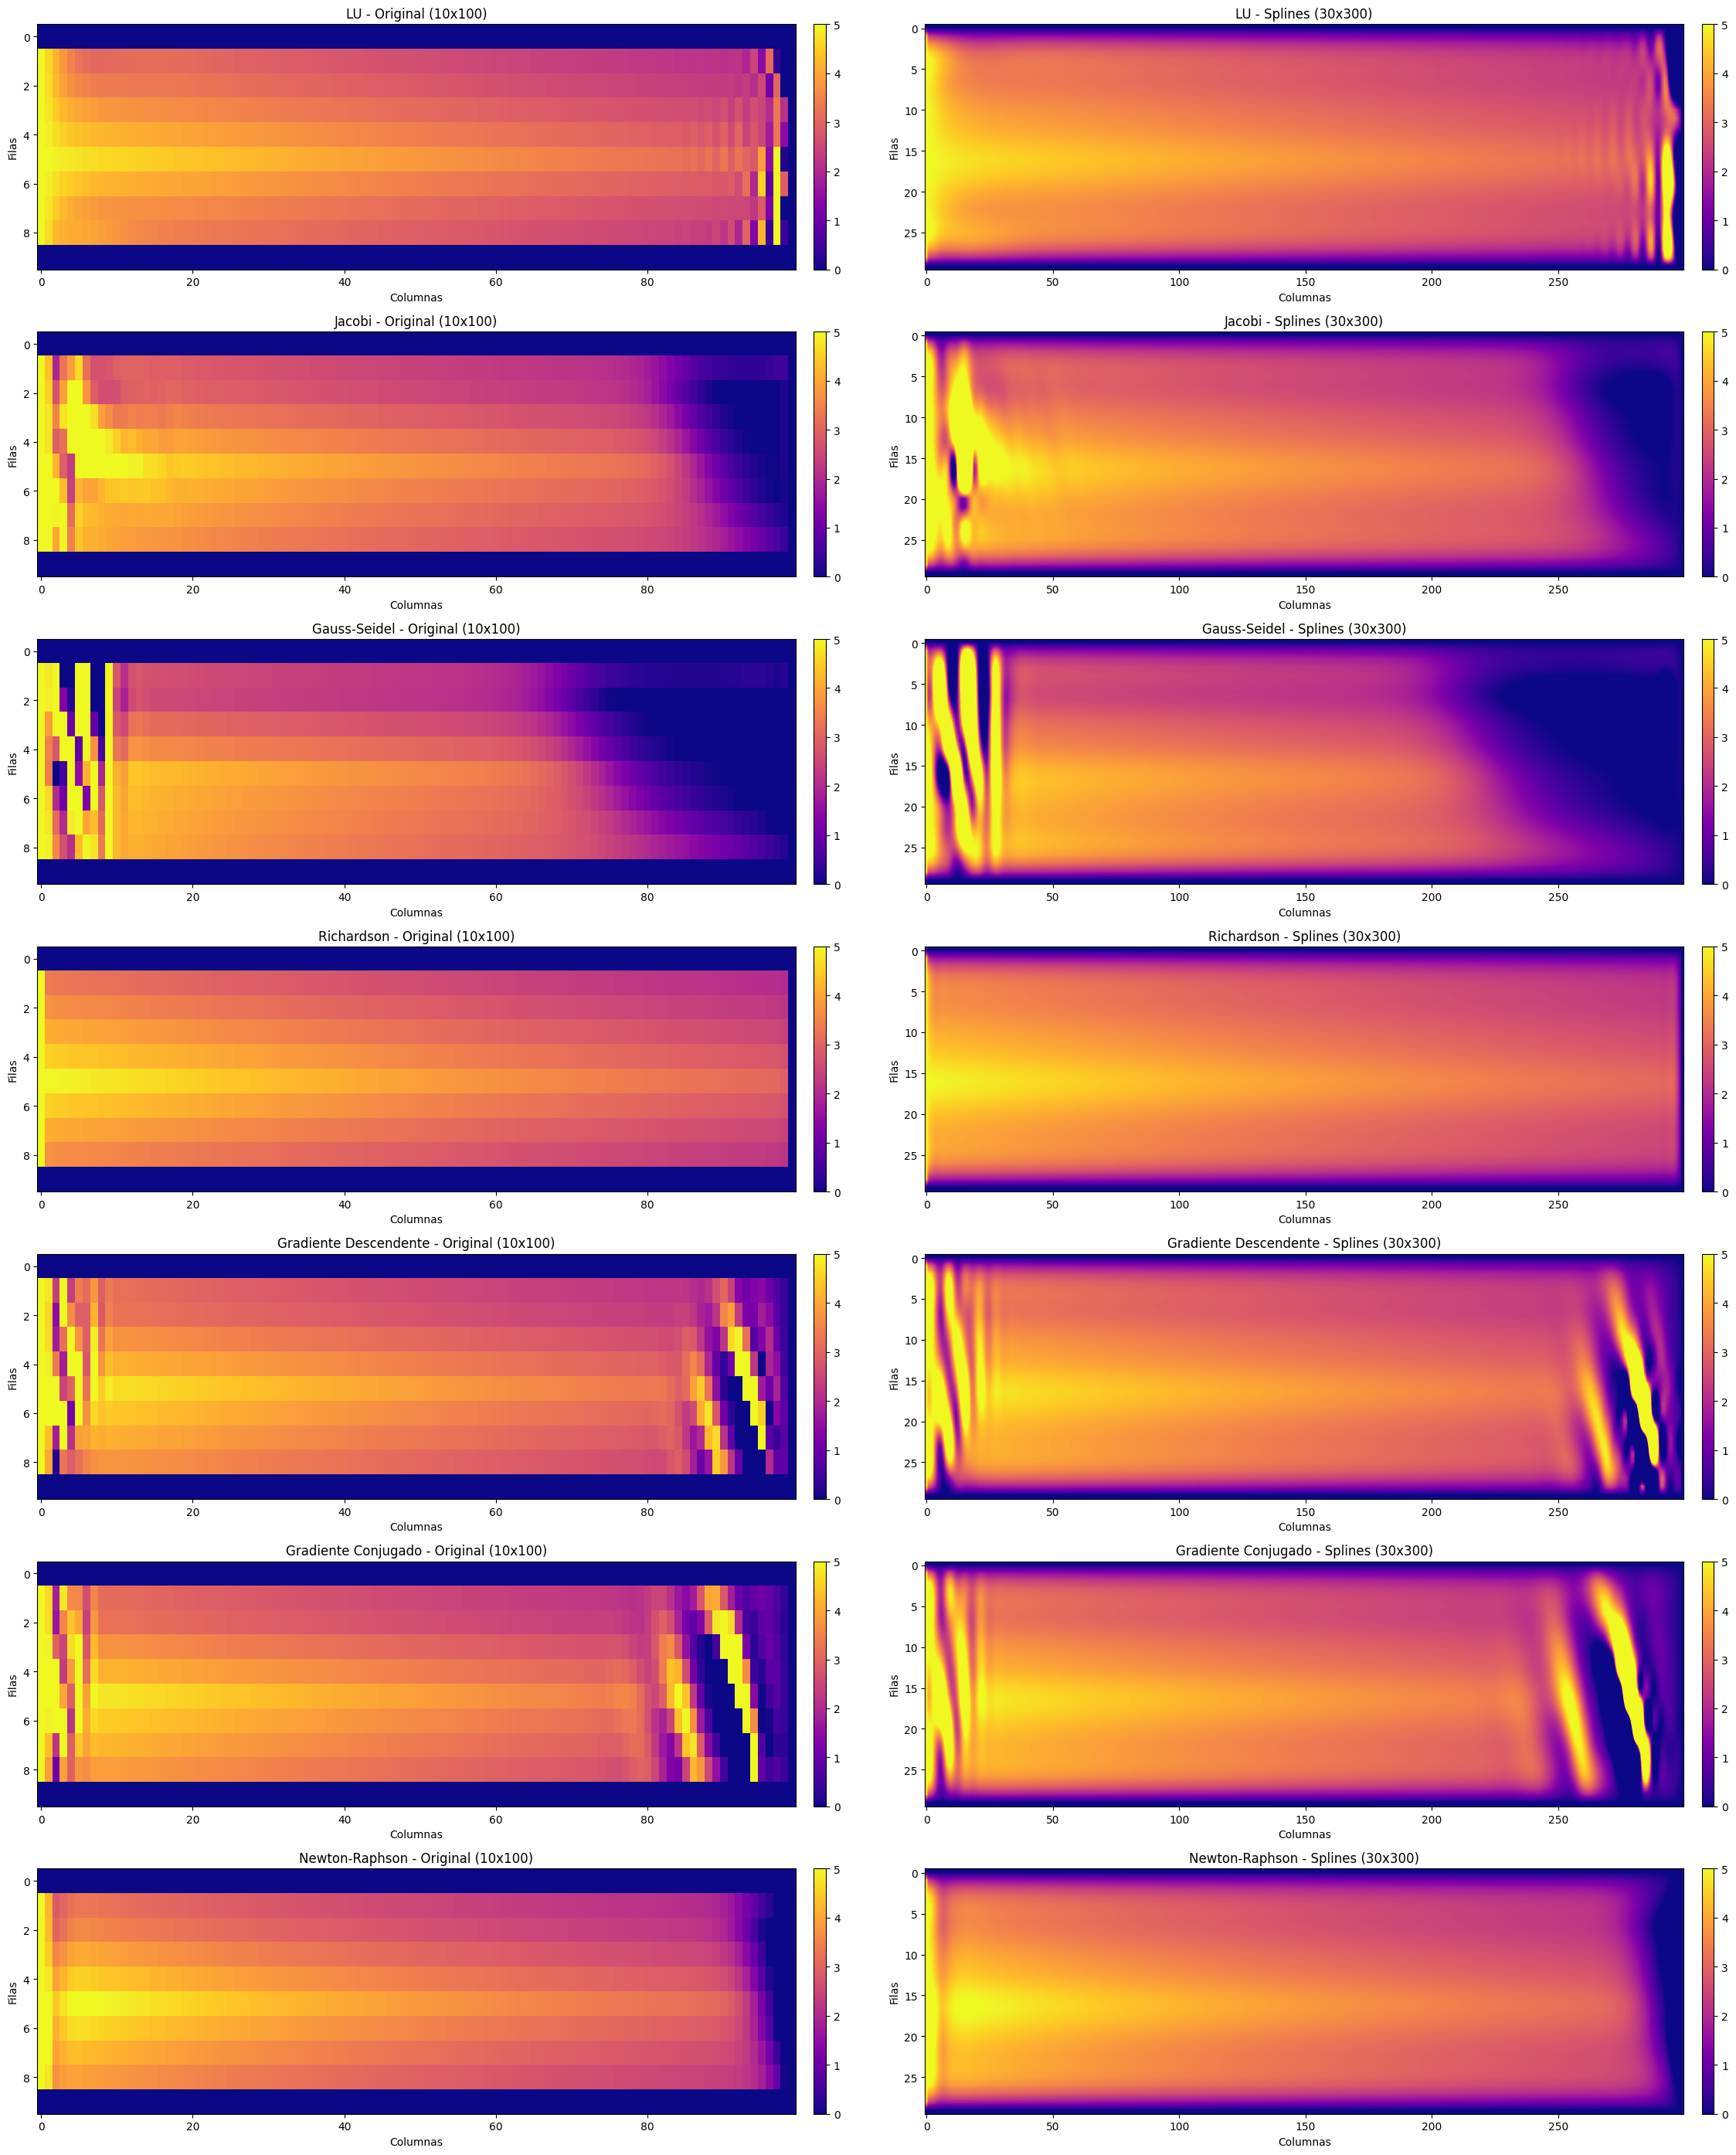

Aplicando splines a LU...
Aplicando splines a Jacobi...
Aplicando splines a Gauss-Seidel...
Aplicando splines a Richardson...
Aplicando splines a Gradiente Descendente...
Aplicando splines a Gradiente Conjugado...
Aplicando splines a Newton-Raphson...


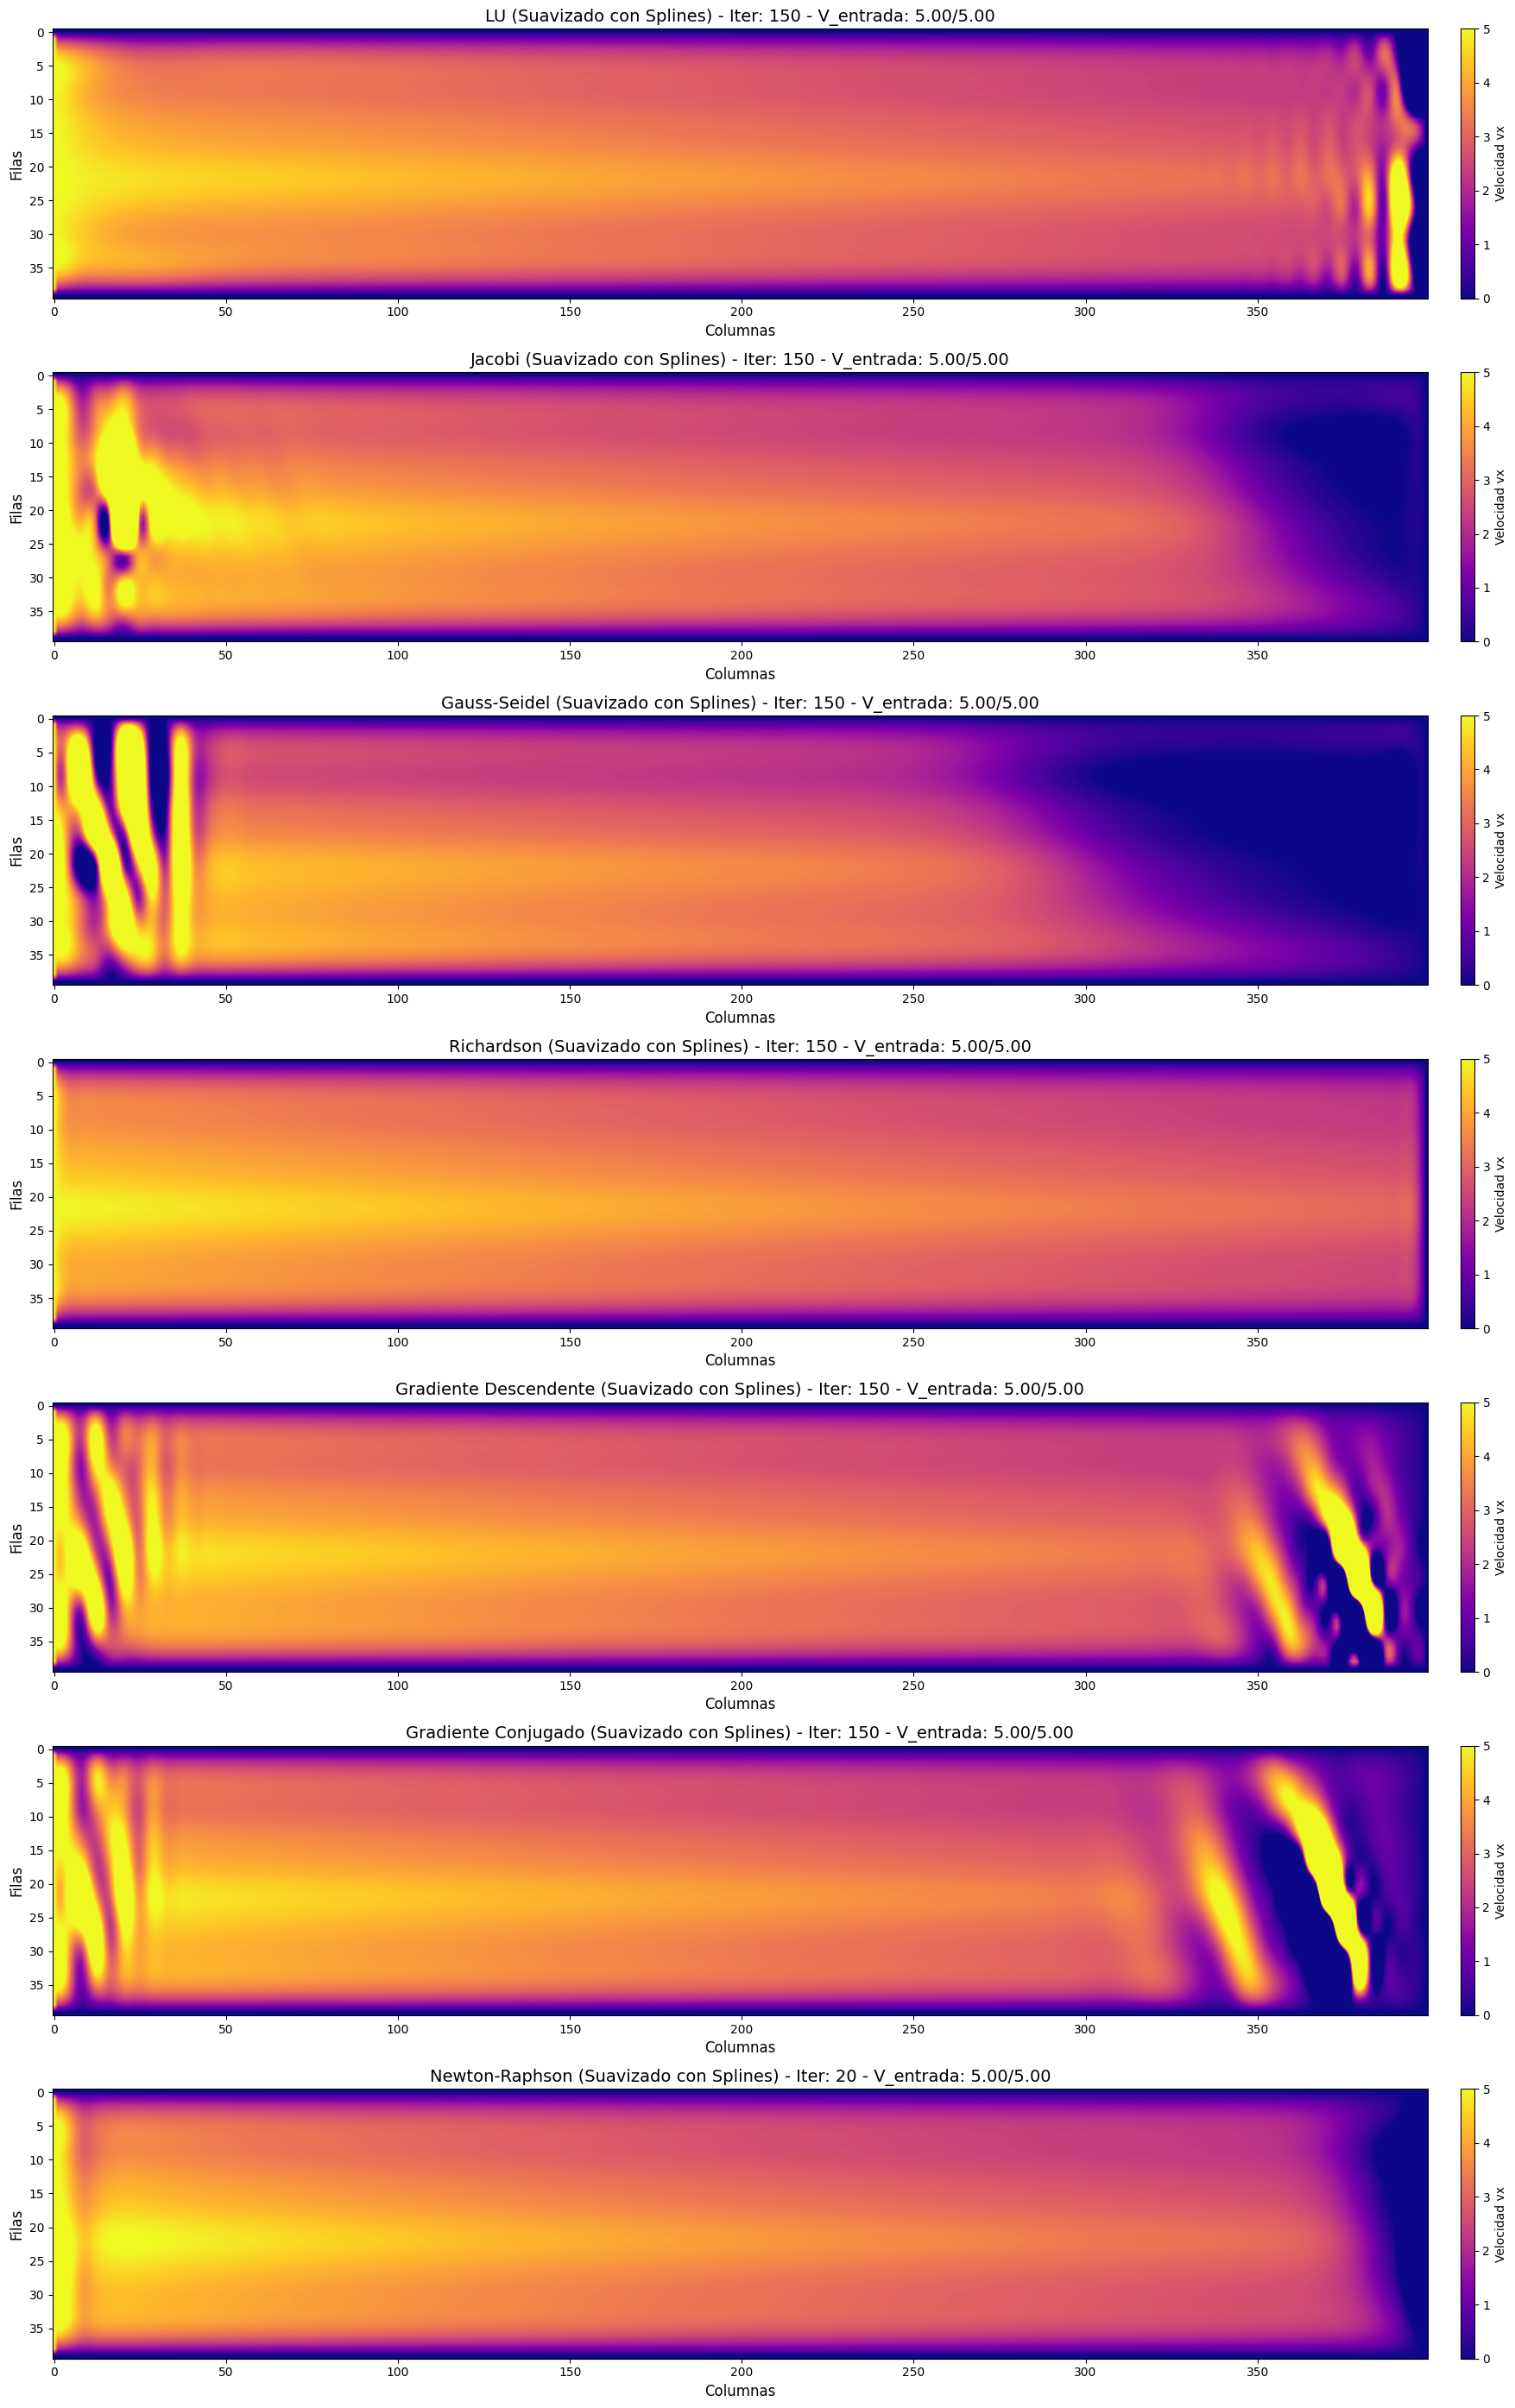


=== LÍNEAS DE CORRIENTE PARA MÉTODOS ESTABLES ===


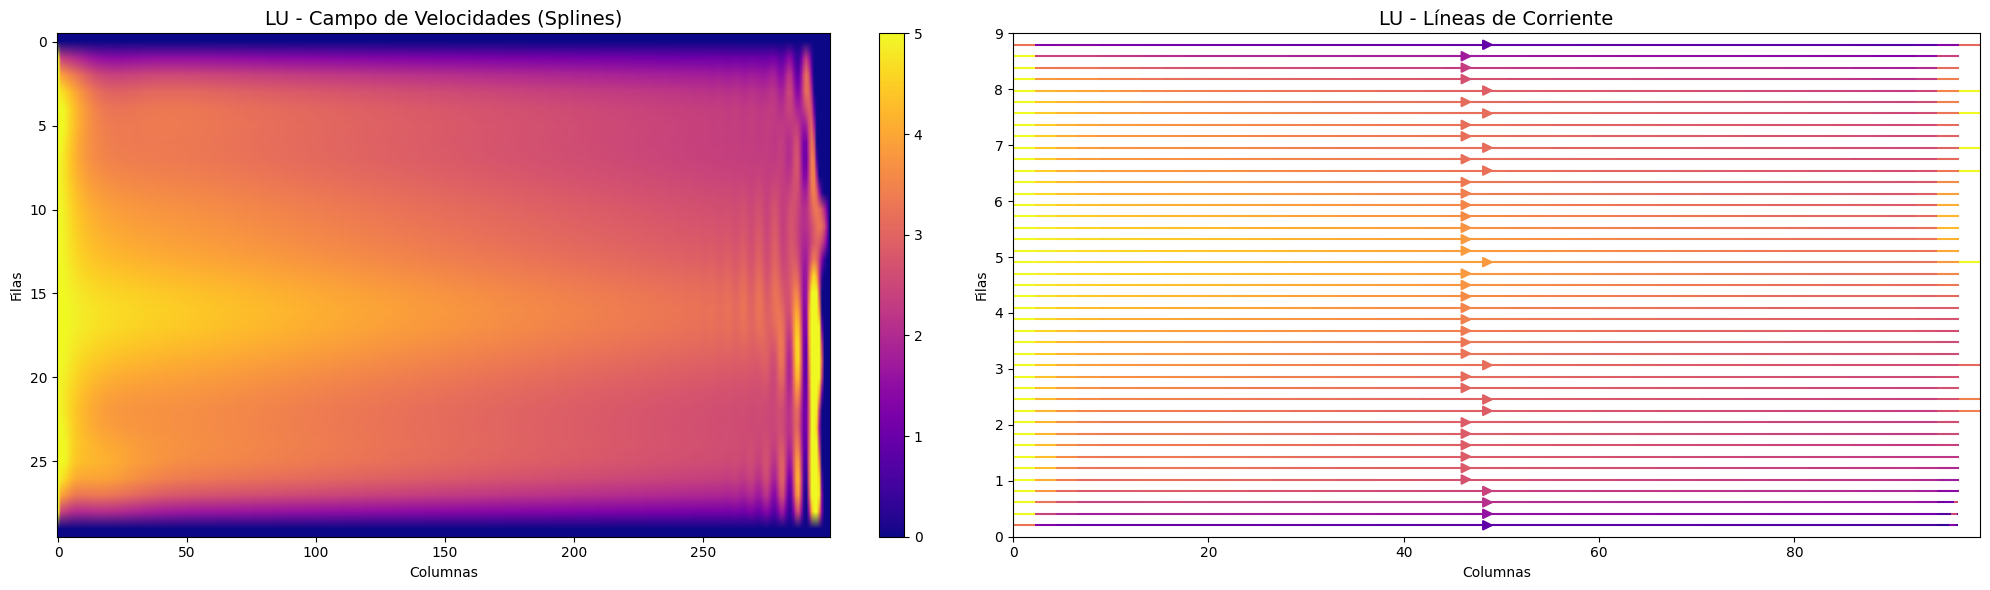

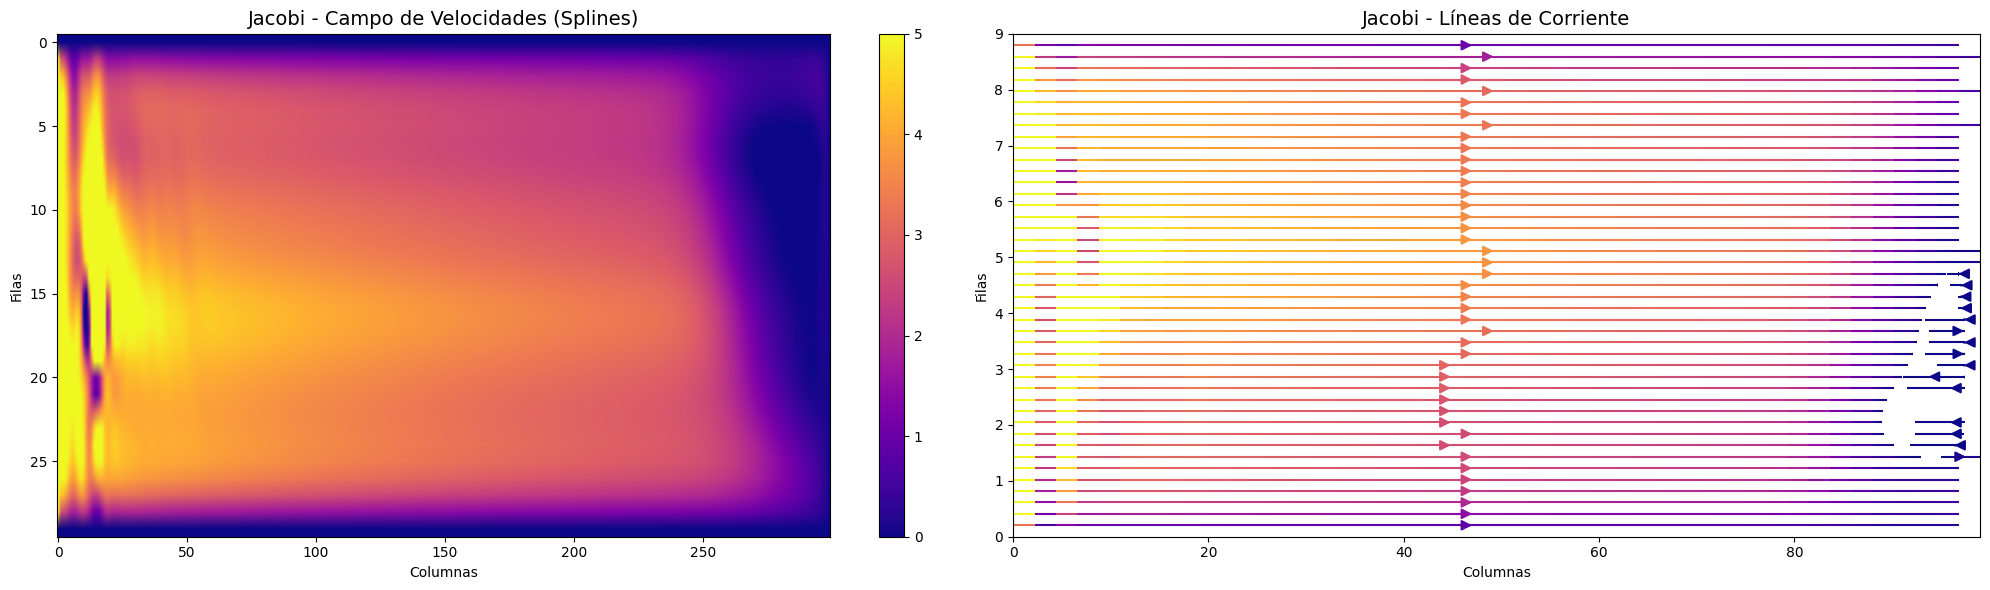

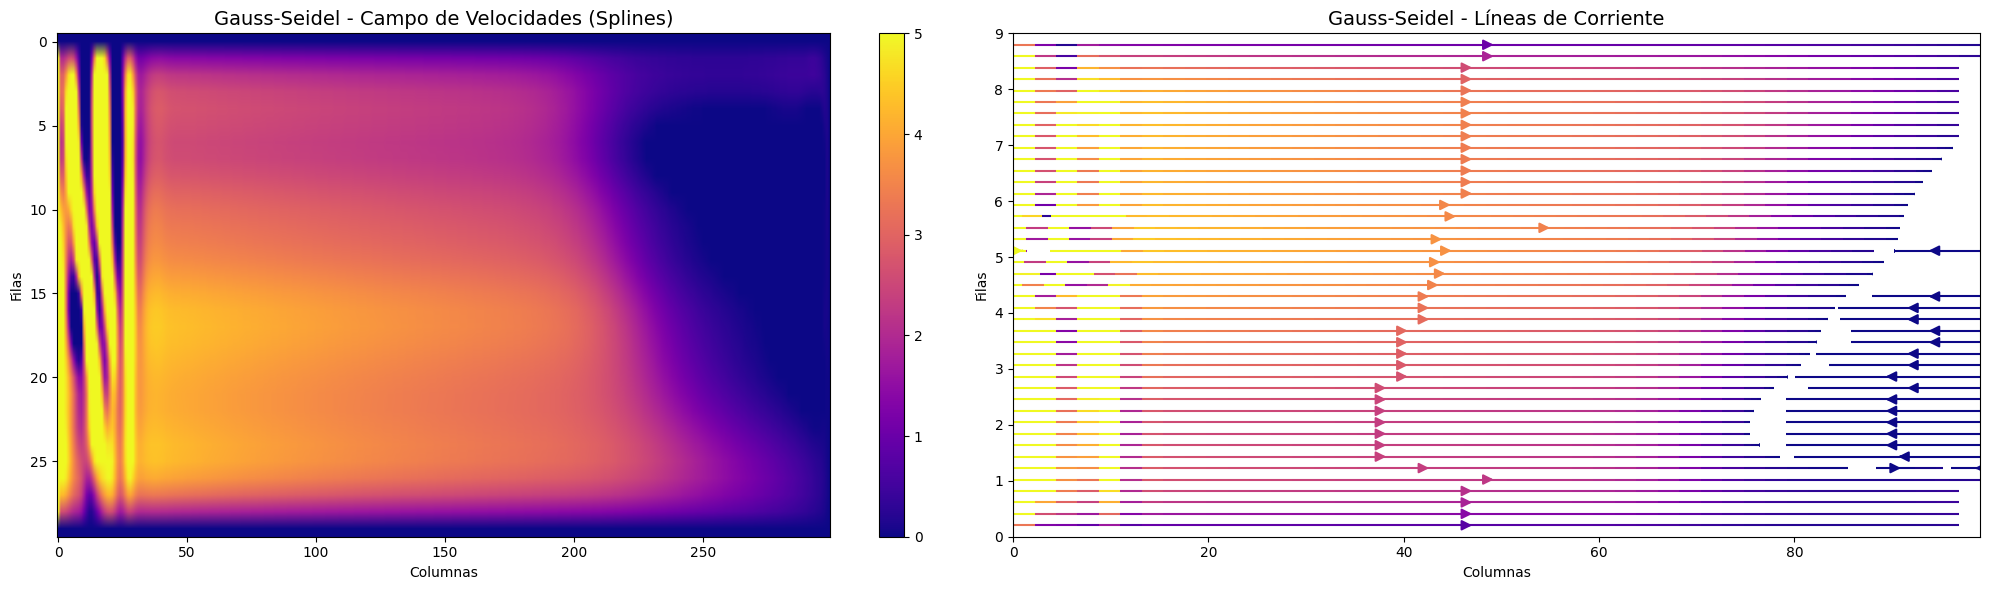

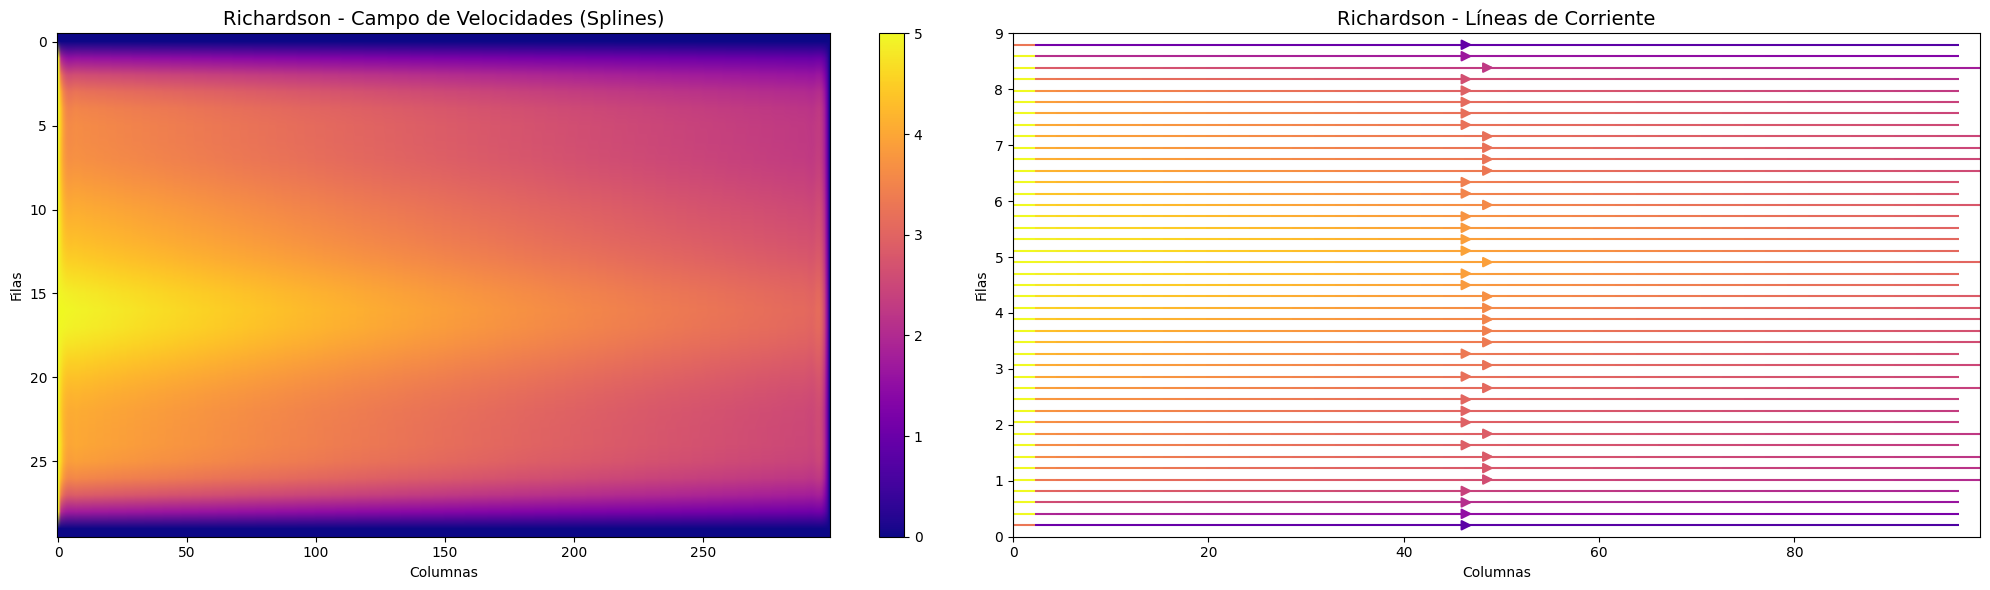

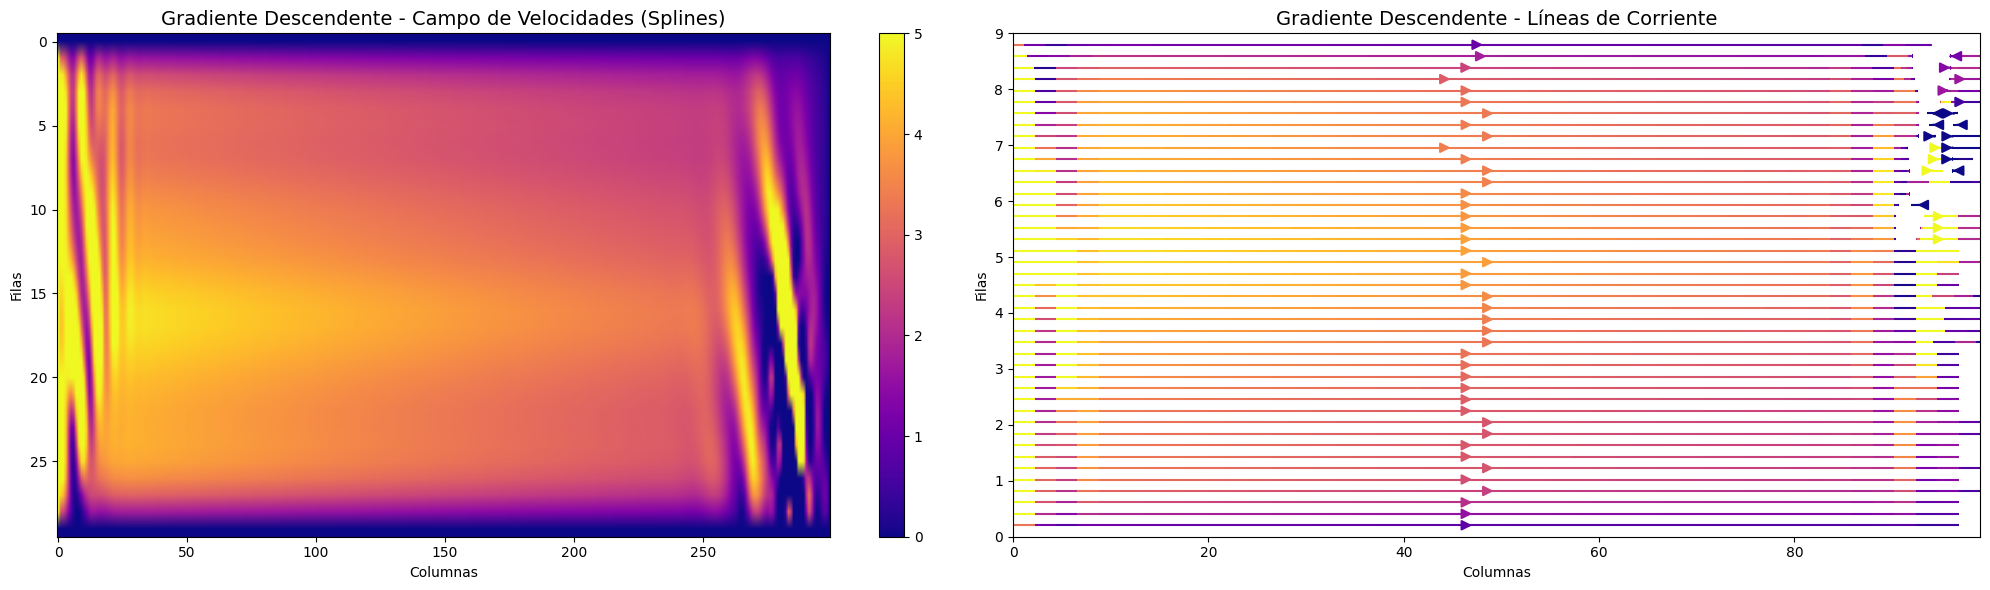

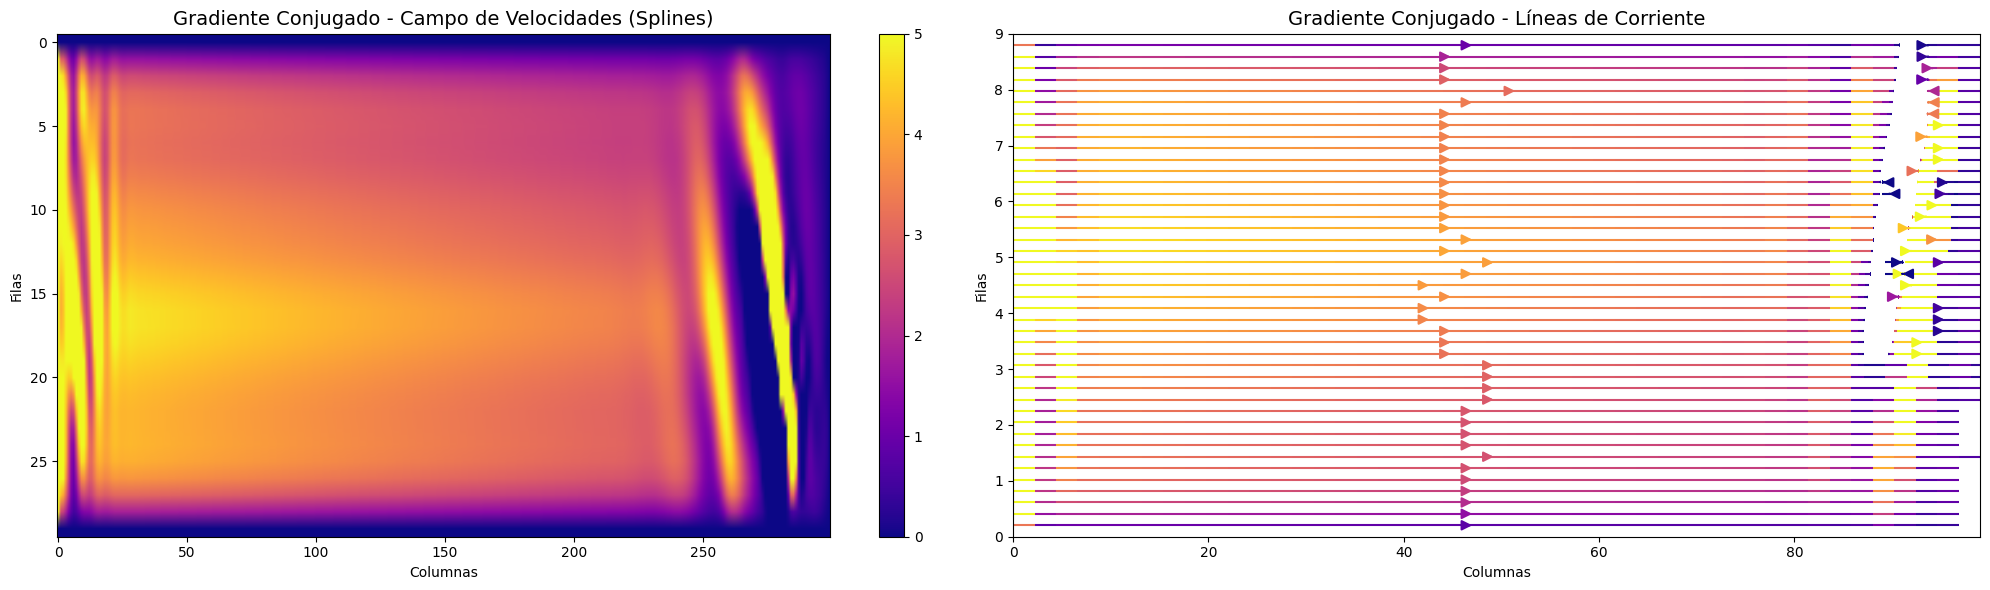

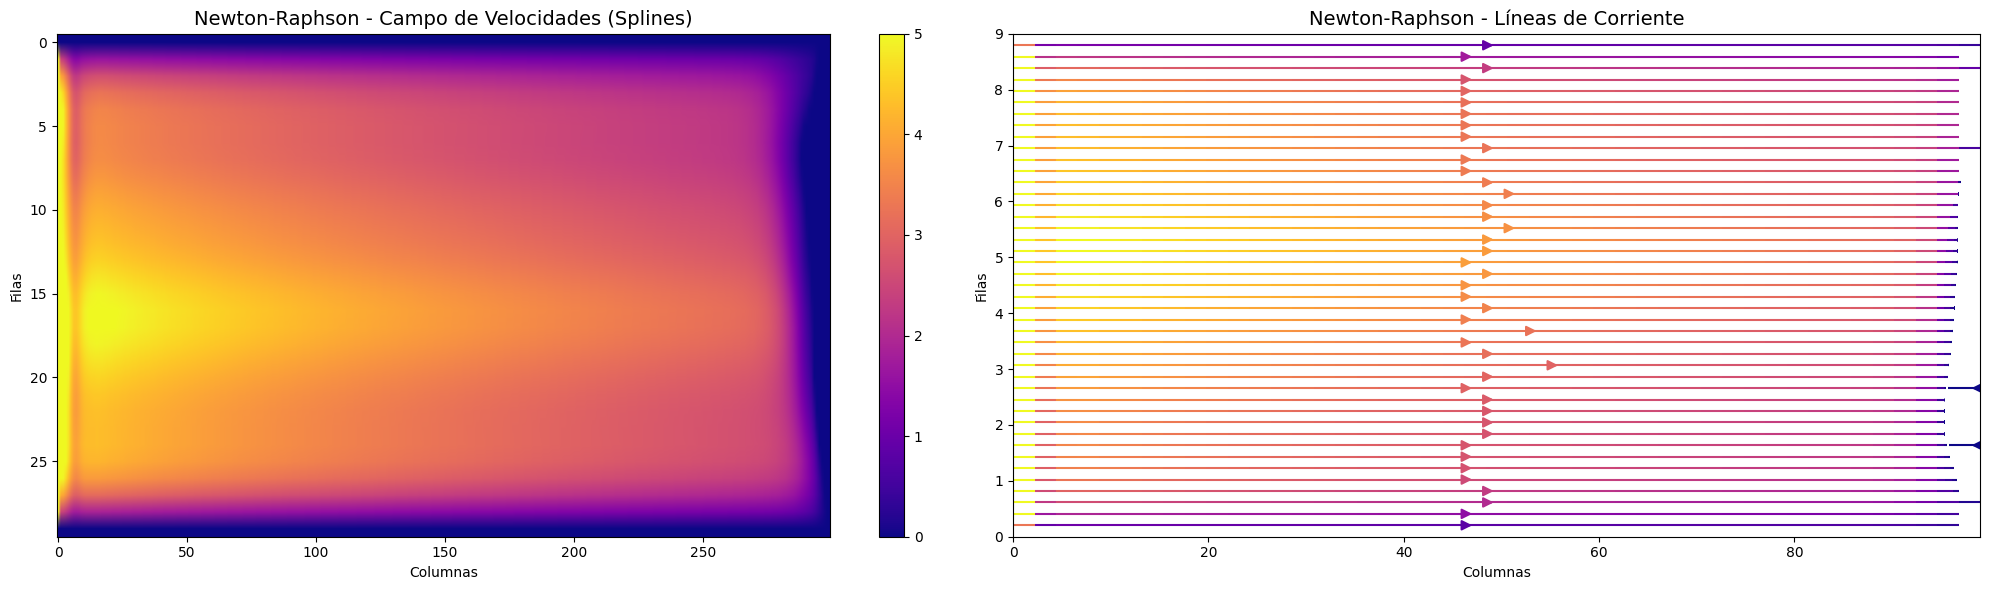

Guardado: Newton-Raphson_HD.png


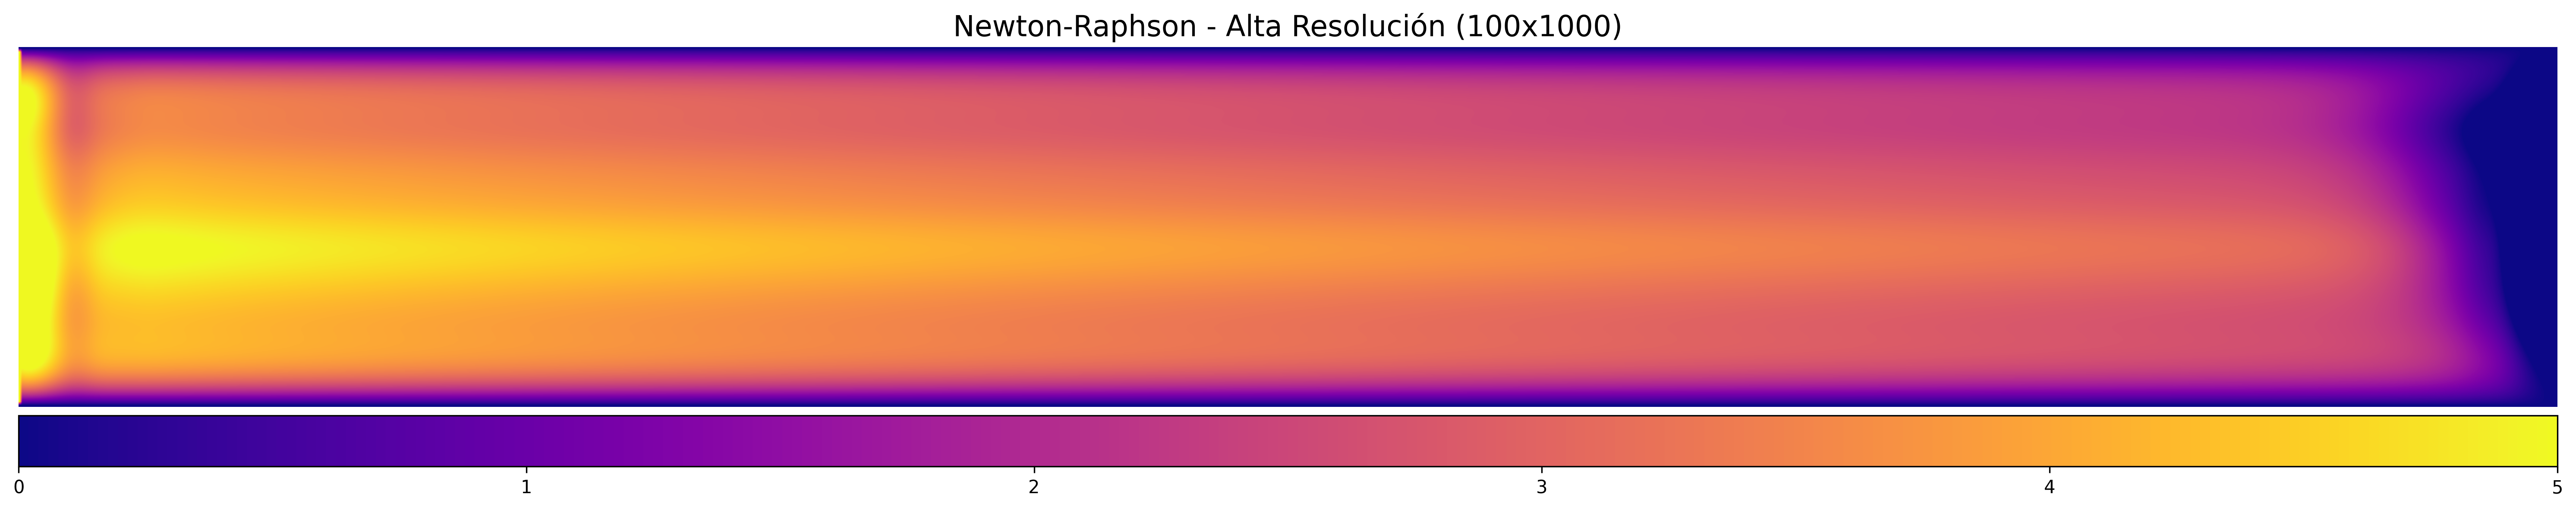

In [80]:
print("\n=== VISUALIZACIÓN CON SPLINES ===")

graficar_comparacion_con_splines(metodos_completos, factor_refinamiento=3)

graficar_solo_splines(metodos_completos, factor_refinamiento=4)


metodos_estables = {}
for nombre, (matriz_vx, matriz_vy, iter) in metodos_completos.items():
    if not np.any(np.isnan(matriz_vx[1:-1, 1:-1])) and np.max(np.abs(matriz_vx[1:-1, 1:-1])) < 10 * VELOCIDAD_ENTRADA:
        metodos_estables[nombre] = (matriz_vx, matriz_vy, iter)

print("\n=== LÍNEAS DE CORRIENTE PARA MÉTODOS ESTABLES ===")
for nombre, (matriz_vx, matriz_vy, _) in metodos_estables.items():
    crear_animacion_flujo(matriz_vx, nombre, factor_refinamiento=3)

def exportar_resultado_alta_resolucion(vx_matrix, nombre_metodo, factor=10):
    """
    Exporta un resultado con muy alta resolución usando splines
    """
    vx_hd, _, _ = aplicar_splines_a_resultado(vx_matrix, factor)
    
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    
    fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
    norm = Normalize(vmin=0, vmax=VELOCIDAD_ENTRADA)
    
    im = ax.imshow(vx_hd, cmap='plasma', norm=norm, aspect='auto', interpolation='bilinear')
    ax.set_title(f'{nombre_metodo} - Alta Resolución ({vx_hd.shape[0]}x{vx_hd.shape[1]})', fontsize=16)
    ax.axis('off') 
    
    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, aspect=50)
    plt.tight_layout()
    
    filename = f"{nombre_metodo.replace(' ', '_')}_HD.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Guardado: {filename}")
    plt.show()

if 'Newton-Raphson' in metodos_estables:
    exportar_resultado_alta_resolucion(metodos_estables['Newton-Raphson'][0], 'Newton-Raphson', factor=10)